# 阿尔兹海默症诊断场景下对3D-ResNet转化为脉冲神经网络SNN的性能测试
设想包括以下三部分内容：
1. 荟萃数据整理与meta数据集准；
2. 使用sMRI图像和3D-RESNET实现AD vs NC的分类；
3. 基于Braincog库实现3D-ResNet向SNN的转化

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import string
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from einops import rearrange,repeat
from torch.utils.data import TensorDataset
from collections import Counter
from torchinfo import summary
import gc
from d2l import torch as d2l
import npx
import math
from scipy.ndimage import rotate  # 用于数据增强的旋转
import copy
import os
from glob import glob
import nibabel as nib              # 医学MRI数据处理
import sys
#np.set_printoptions(threshold=np.inf)

## PART1：荟萃数据集整理与神经网络预训练
打算纳入考量的数据集包括：
1. 人口统计学数据：性别(Sex)、年龄(Age)
2. 基因数据：主要是APOE4的两个关联基因(APGEN1，APGEN2)
3. MRI图像提取的指标：
  - USCF海马体体积(LEFTHIPPO，RIGHTHIPPO)
  - UCD全颅体积(T2TCV)
  - UCD高强度白质体积(WHITMATHYP)
4. 量表评估结果：
  - MMSE量表总分(MMSCORE)
  - ADAS-cog两部分评分(TOTAL11,TOTALMOD)
  - CDR6方面评估+1个全局认知评估(CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL)
 
 共计指标18个。本程序主要包括两部分，第一部分是通过pandas完成数据的合并，第二部分是通过pytorch构建BP神经网络进行训练/预训练，通过类似逐步回归的方式实现特征的筛选。

### 1.1：一维指标数据整理和表格归并

#### 1.1.1 基准文件导入与人口统计学信息归并
涉及的表格：
- 人口统计学信息(整理后的标准数据集)；
- diag_summary(获取PTID对应的RID)。

涉及的指标：
- 性别(Sex)
- 年龄(Age)

In [2]:
# 导入标准数据集
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/ADNI-sc标准集.csv"
basic_scdata = pd.read_csv(file_path)
basic_scdata

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI
...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI


In [3]:
# 导入诊断数据
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/diag_summary.csv"
diag_summary = pd.read_csv(file_path)
diag_summary

,Phase,ID,RID,PTID,SITEID,VISCODE,VISCODE2,VISDATE,USERDATE,EXAMDATE,...,DXAPP,DXAPROB,DXAPOSS,DXPARK,DXPDES,DXPCOG,DXPATYP,DXOTHDEM,DXODES,DXCONFID
0,ADNI1,408,295,002_S_0295,101,bl,bl,2006/5/10,2006/5/10,2006/5/10,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
1,ADNI1,1388,295,002_S_0295,101,m06,m06,2006/11/8,2006/11/10,2006/11/8,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
2,ADNI1,2956,295,002_S_0295,101,m12,m12,2007/5/25,2007/5/29,2007/5/25,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
3,ADNI1,5752,295,002_S_0295,101,m24,m24,2008/8/4,2008/9/5,2008/8/4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
4,ADNI1,6684,295,002_S_0295,101,m36,m36,2009/5/26,2009/5/26,2009/5/26,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3863,ADNI1,5192,1311,941_S_1311,127,m12,m12,2008/4/23,2008/5/6,2008/4/23,...,1,1,-4,-4,-4,-4,-4,-4,-4,3
3864,ADNI1,5908,1311,941_S_1311,127,m18,m18,2008/10/8,2008/10/8,2008/10/8,...,1,1,-4,-4,-4,-4,-4,-4,-4,3
3865,ADNI1,6534,1311,941_S_1311,127,m24,m24,2009/3/30,2009/3/31,2009/3/30,...,1,1,-4,-4,-4,-4,-4,-4,-4,4
3866,ADNI1,2466,1363,941_S_1363,127,bl,bl,2007/3/27,2007/3/27,2007/3/27,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4


In [4]:
# 提取diag_summary中的bl数据
diag_summary_bl = diag_summary[diag_summary['VISCODE'] == 'bl']
diag_summary_bl

,Phase,ID,RID,PTID,SITEID,VISCODE,VISCODE2,VISDATE,USERDATE,EXAMDATE,...,DXAPP,DXAPROB,DXAPOSS,DXPARK,DXPDES,DXPCOG,DXPATYP,DXOTHDEM,DXODES,DXCONFID
0,ADNI1,408,295,002_S_0295,101,bl,bl,2006/5/10,2006/5/10,2006/5/10,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
6,ADNI1,406,413,002_S_0413,101,bl,bl,2006/5/10,2006/5/10,2006/5/10,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
12,ADNI1,634,559,002_S_0559,101,bl,bl,2006/6/27,2006/6/27,2006/6/27,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
17,ADNI1,632,619,002_S_0619,101,bl,bl,2006/6/27,2006/6/27,2006/6/27,...,1,1,-4,-4,-4,-4,-4,-4,-4,4
21,ADNI1,734,685,002_S_0685,101,bl,bl,2006/7/24,2006/7/24,2006/7/24,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,ADNI1,2014,1202,941_S_1202,127,bl,bl,2007/2/12,2007/2/12,2007/2/12,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
3851,ADNI1,2142,1203,941_S_1203,127,bl,bl,2007/2/22,2007/2/23,2007/2/22,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
3856,ADNI1,2176,1295,941_S_1295,127,bl,bl,2007/2/28,2007/2/28,2007/2/28,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4
3861,ADNI1,2398,1311,941_S_1311,127,bl,bl,2007/3/19,2007/3/20,2007/3/19,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,4


In [5]:
# 测试.values函数的输出形式
basic_scdata['Subject'].values[0:20]

array(['002_S_0295', '002_S_0413', '002_S_0559', '002_S_0619',
       '002_S_0685', '002_S_0729', '002_S_0782', '002_S_0816',
       '002_S_0938', '002_S_0954', '002_S_0955', '002_S_1018',
       '002_S_1070', '002_S_1155', '002_S_1261', '002_S_1268',
       '002_S_1280', '003_S_0907', '003_S_0908', '003_S_0931'],
      dtype=object)

In [6]:
# 确定可以通过len函数获取某一列的长度
len(basic_scdata['Subject'].values) 

818

In [7]:
# 扩容标准数据集，加入ID和RID
# basic_scdata.insert(basic_scdata.shape[1],'ID',0)
# basic_scdata.insert(basic_scdata.shape[1],'RID',0)
basic_scdata['ID'] = 0   
basic_scdata['RID']= 0
basic_scdata

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,0,0
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,0,0
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,0,0
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,0,0
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,0,0
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,0,0
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,0,0
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,0,0


In [8]:
# 将ID和RID导入
for i in basic_scdata['Subject']:
    # print(basic_scdata['Subject']==i)
    # print(i)
    # print(diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values)
    # 需要通过.loc进行定位才能进行赋值
    basic_scdata.loc[basic_scdata['Subject']==i,'ID'] = diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'RID']= diag_summary_bl[diag_summary_bl['PTID']==i]['RID'].values
    
basic_scdata

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685
...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,2014,1202
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,2142,1203
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,2176,1295
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,2398,1311


#### 1.1.2 基因数据导入与归并
涉及的表格：
- APOE(APOE相关基因数据集)；

涉及的指标：
- 载脂蛋白ApoE4基因检测1(APGEN1)
- 载脂蛋白ApoE4基因检测2(APGEN2)

In [9]:
# 扩容标准数据集，加入APGEN1和APGEN2
basic_scdata['APGEN1'] = np.nan
basic_scdata['APGEN2'] = np.nan
basic_scdata

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,NaN,NaN
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,NaN,NaN
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,NaN,NaN
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,NaN,NaN
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,2014,1202,NaN,NaN
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,2142,1203,NaN,NaN
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,2176,1295,NaN,NaN
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,2398,1311,NaN,NaN


In [10]:
# 导入基因指标集
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/APOE.csv"
APOE_data = pd.read_csv(file_path)
APOE_data

,Phase,ID,PTID,RID,SITEID,VISCODE,USERDATE,USERDATE2,APTESTDT,APGEN1,APGEN2,APVOLUME,APRECEIVE,APAMBTEMP,APRESAMP,APUSABLE,update_stamp
0,ADNI1,4.0,011_S_0002,2,107.0,sc,2005-08-23,NaN,2005-08-22,3,3,5.0,1.0,1.0,0.0,1.0,2005-08-23 00:00:00.0
1,ADNI1,6.0,011_S_0003,3,107.0,sc,2005-08-23,NaN,2005-08-22,3,4,10.0,1.0,1.0,0.0,1.0,2005-08-23 00:00:00.0
2,ADNI1,8.0,022_S_0004,4,10.0,sc,2005-08-23,NaN,2005-08-22,3,3,9.2,1.0,1.0,0.0,1.0,2005-08-23 00:00:00.0
3,ADNI1,10.0,011_S_0005,5,107.0,sc,2005-08-29,NaN,2005-08-29,3,3,10.0,1.0,1.0,0.0,1.0,2005-08-29 00:00:00.0
4,ADNI1,12.0,022_S_0007,7,10.0,sc,2005-09-06,NaN,2005-09-05,3,4,9.0,1.0,1.0,0.0,1.0,2005-09-06 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,ADNI3,NaN,014_S_7080,7080,NaN,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,2023-11-22 23:32:16.0
2733,ADNI3,NaN,073_S_7082,7082,NaN,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,2023-11-22 23:32:16.0
2734,ADNI3,NaN,126_S_7083,7083,NaN,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,2023-11-22 23:32:16.0
2735,ADNI3,NaN,021_S_7092,7092,NaN,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,2023-11-22 23:32:16.0


In [11]:
# 将APGEN1和APGEN2导入(基因数据还是挺全的)
for i in basic_scdata['Subject']:
    # print(basic_scdata['Subject']==i)
    # print(i)
    # print(diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values)
    # 需要通过.loc进行定位才能进行赋值
    if len(APOE_data[APOE_data['PTID']==i]['APGEN1'].values) != 1:
        print(len(APOE_data[APOE_data['PTID']==i]['APGEN1'].values))  # 无额外输出，说明数据规整
    basic_scdata.loc[basic_scdata['Subject']==i,'APGEN1'] = APOE_data[APOE_data['PTID']==i]['APGEN1'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'APGEN2'] = APOE_data[APOE_data['PTID']==i]['APGEN2'].values
    # print(APOE_data[APOE_data['PTID']==i]['APGEN1'].values,APOE_data[APOE_data['PTID']==i]['APGEN2'].values)
basic_scdata

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,2014,1202,3.0,3.0
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,2142,1203,3.0,3.0
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,2176,1295,3.0,4.0
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,2398,1311,4.0,4.0


#### 1.1.3 导入MRI图像提取指标
涉及的表格：
- UCSF-海马体体积数据；
- UCD-全颅体积数据；
- UCD-高强度白质体积；

涉及的指标：
- 左/右海马体体积(LEFTHIPPO，RIGHTHIPPO)
- T2总颅内体积(T2TCV)
- 白质高强度体积(WHITMATHYP)

In [12]:
# 增加UCSF-海马体相关指标：
basic_scdata['LEFTHIPPO'] = np.nan
basic_scdata['RIGHTHIPPO'] = np.nan
# 增加UCD-全颅体积指标
basic_scdata['T2TCV'] = np.nan
# 增加UCD-白质高强度体积指标
basic_scdata['WHITMATHYP'] = np.nan
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0,NaN,NaN,NaN,NaN
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0,NaN,NaN,NaN,NaN
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0,NaN,NaN,NaN,NaN
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0,NaN,NaN,NaN,NaN
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0,NaN,NaN,NaN,NaN


In [13]:
# 导入UCSF提取的海马体体积数据
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/Hippocampal-Volumes-UCSF.csv"
Hippocampal_Volumes = pd.read_csv(file_path)
Hippocampal_Volumes

,RID,SITEID,VISCODE,USERDATE,RECNO,EXAMDATE,LONISID,LONIUID,IMAGEUID,FLDSTRENG,SNTDATE,ATLAS,LEFTHIPPO,RIGHTHIPPO,update_stamp
0,58,11,bl,2009-03-12,1,2005-12-12,2763,10498,30968,3.0,2007-07-26,HippoUCSF,2428.32,2260.58,2009-03-12 00:00:00.0
1,58,11,m06,2009-03-12,1,2006-06-13,4175,15504,30979,3.0,2007-07-26,HippoUCSF,2575.13,2394.65,2009-03-12 00:00:00.0
2,58,11,m06,2009-03-12,2,2006-06-22,4254,15796,31008,1.5,2007-07-26,HippoUCSF,2434.45,2351.90,2009-03-12 00:00:00.0
3,42,11,sc,2009-03-12,1,2005-10-31,2605,8852,31084,1.5,2007-07-23,HippoUCSF,1271.86,1098.43,2009-03-12 00:00:00.0
4,42,11,m06,2009-03-12,1,2006-05-03,3726,13959,31093,1.5,2007-07-26,HippoUCSF,1080.93,1064.91,2009-03-12 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,138,115,sc,2009-03-12,1,2006-01-25,2968,11204,104521,1.5,2008-06-03,HippoUCSF,1920.01,2025.06,2009-03-12 00:00:00.0
1870,1202,127,m12,2009-03-12,1,2008-02-28,14922,46683,105437,1.5,2008-06-05,HippoUCSF,1568.13,1762.71,2009-03-12 00:00:00.0
1871,1240,17,m12,2009-03-12,1,2008-03-04,14897,49622,105750,1.5,2008-06-05,HippoUCSF,1326.03,1532.38,2009-03-12 00:00:00.0
1872,1389,118,m12,2009-03-12,2,2008-04-24,15659,49258,105791,1.5,2008-06-04,HippoUCSF,1661.82,1602.59,2009-03-12 00:00:00.0


In [14]:
# 导入UCD提取的全颅体积数据
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/UCD-Total cranial volumes.csv"
Total_cranial_volumes = pd.read_csv(file_path)
Total_cranial_volumes

,RID,VISCODE,EXAMDATE,LONIUID,RUNDATE,STATUS,VERSION,T2TCV,GRADE,update_stamp
0,2,sc,2005-08-26,I7023 I7024,2012-07-15,complete,1,1672.29,3,2013-01-29 14:27:31.0
1,3,sc,2005-09-01,I7053 I7054,2012-07-15,complete,1,1717.60,3,2013-01-29 14:27:31.0
2,4,sc,2006-05-25,I7272 I7273,2012-07-15,complete,1,1518.17,2,2013-01-29 14:27:31.0
3,5,sc,2005-09-02,I7069 I7070,2012-07-15,complete,1,1546.52,2,2013-01-29 14:27:31.0
4,6,sc,2005-11-15,I8795 I8794,2012-07-15,complete,1,1422.81,2,2013-01-29 14:27:31.0
...,...,...,...,...,...,...,...,...,...,...
805,1425,sc,2007-08-06,I136925 I136918,2012-07-15,complete,1,1215.55,2,2013-01-29 14:27:32.0
806,1426,sc,2007-09-07,I72084 I72082,2012-07-15,complete,1,1597.01,2,2013-01-29 14:27:32.0
807,1427,sc,2007-08-20,I69354 I69355,2012-07-15,complete,1,1447.24,3,2013-01-29 14:27:32.0
808,1430,sc,2007-09-07,I72764 I72765,2012-07-15,complete,1,1143.80,2,2013-01-29 14:27:32.0


In [15]:
# 导入UCD提取的白质高强度体积数据
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/UCD-white matter hyperintensity.csv"
white_matter_hyperintensity = pd.read_csv(file_path)
white_matter_hyperintensity

,RID,EXAMDATE,VISCODE,WHITMATHYP,MANUFACTURER,MODEL,MAGSTRENGTH,SEGPROCIMG,SEGPROC,update_stamp
0,2,2005/8/26,sc,0.707101,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5,DSE,Method 1,50:17.0
1,3,2006/3/13,m06,4.445950,SIEMENS,Sonata,1.5,DSE,Method 1,50:17.0
2,3,2005/9/1,sc,5.161660,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5,DSE,Method 1,50:17.0
3,3,2006/9/12,m12,9.322250,SIEMENS,Symphony,1.5,DSE,Method 1,50:17.0
4,3,2007/9/12,m24,8.718740,GE MEDICAL SYSTEMS,SIGNA HDx,1.5,DSE,Method 1,50:17.0
...,...,...,...,...,...,...,...,...,...,...
3463,1427,2009/8/26,m24,0.022906,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5,DSE,Method 1,50:19.0
3464,1427,2008/9/2,m12,0.016064,SIEMENS,Sonata,1.5,DSE,Method 1,50:19.0
3465,1430,2008/4/4,m06,5.039970,GE MEDICAL SYSTEMS,Signa HDxt,1.5,DSE,Method 1,50:19.0
3466,1430,2007/9/7,sc,0.729491,SIEMENS,Avanto,1.5,DSE,Method 1,50:19.0


In [16]:
# 将'WHITMATHYP'导入,RID索引，只选择sc
# 经过校对，删除了RID1157患者2006年的重复测试数据
for i in basic_scdata['RID']:
    #print(i)
    #print(white_matter_hyperintensity[(white_matter_hyperintensity['RID']==i) & (white_matter_hyperintensity['VISCODE']=='sc')]['WHITMATHYP'].values)
    #print(basic_scdata.loc[basic_scdata['RID']==i,'WHITMATHYP'])
    if white_matter_hyperintensity[(white_matter_hyperintensity['RID']==i) & (white_matter_hyperintensity['VISCODE']=='sc')]['WHITMATHYP'].values.size >0:
       basic_scdata.loc[basic_scdata['RID']==i,'WHITMATHYP'] = white_matter_hyperintensity[(white_matter_hyperintensity['RID']==i) & (white_matter_hyperintensity['VISCODE']=='sc')]['WHITMATHYP'].values
    # basic_scdata.loc[basic_scdata['Subject']==i,'APGEN2']= APOE_data[APOE_data['PTID']==i]['APGEN2'].values
    # print(APOE_data[APOE_data['PTID']==i]['APGEN1'].values,APOE_data[APOE_data['PTID']==i]['APGEN2'].values)
basic_scdata

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0,NaN,NaN,NaN,0.160051
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0,NaN,NaN,NaN,0.008360
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0,NaN,NaN,NaN,0.294304
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0,NaN,NaN,NaN,0.498404
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0,NaN,NaN,NaN,3.192310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,2014,1202,3.0,3.0,NaN,NaN,NaN,0.343759
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,2142,1203,3.0,3.0,NaN,NaN,NaN,0.171043
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,2176,1295,3.0,4.0,NaN,NaN,NaN,0.569736
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,2398,1311,4.0,4.0,NaN,NaN,NaN,0.879951


In [17]:
# 将全颅体积数据导入，RID索引，原表一共810个数据，相对而言是很规整的。
for i in basic_scdata['RID']:
    # print(len(Total_cranial_volumes[Total_cranial_volumes['RID']==i]['T2TCV'].values))
    # print(Total_cranial_volumes[Total_cranial_volumes['RID']==i]['T2TCV'].values)
    if Total_cranial_volumes[Total_cranial_volumes['RID']==i]['T2TCV'].values.size >0:
       basic_scdata.loc[basic_scdata['RID']==i,'T2TCV'] = Total_cranial_volumes[Total_cranial_volumes['RID']==i]['T2TCV'].values
    # basic_scdata.loc[basic_scdata['Subject']==i,'APGEN2']= APOE_data[APOE_data['PTID']==i]['APGEN2'].values
    # print(APOE_data[APOE_data['PTID']==i]['APGEN1'].values,APOE_data[APOE_data['PTID']==i]['APGEN2'].values)
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0,NaN,NaN,1497.90,0.160051
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0,NaN,NaN,1357.76,0.008360
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0,NaN,NaN,1577.03,0.294304
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0,NaN,NaN,1922.29,0.498404
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0,NaN,NaN,1381.89,3.192310


In [18]:
# 将海马体体积数据导入,分了左海马体和右海马体两个判断
# 有的患者无数据，有的患者有sc/bl中的一个，有的患者sc和bl都有(有一个就选那个，都有就选sc)
for i in basic_scdata['RID']:
    # print(i)
    # print(len(Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['LEFTHIPPO'].values))
    # print(len(Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['RIGHTHIPPO'].values))
    # print(Total_cranial_volumes[Total_cranial_volumes['RID']==i]['T2TCV'].values)
    if len(Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['LEFTHIPPO'].values) == 1:
        basic_scdata.loc[basic_scdata['RID']==i,'LEFTHIPPO'] = Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['LEFTHIPPO'].values
    elif len(Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['LEFTHIPPO'].values) == 2:
        basic_scdata.loc[basic_scdata['RID']==i,'LEFTHIPPO'] = Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & (Hippocampal_Volumes['VISCODE']=='sc')]['LEFTHIPPO'].values

    if len(Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['RIGHTHIPPO'].values) == 1:
        basic_scdata.loc[basic_scdata['RID']==i,'RIGHTHIPPO'] = Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['RIGHTHIPPO'].values
    elif len(Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & ((Hippocampal_Volumes['VISCODE']=='sc') | (Hippocampal_Volumes['VISCODE']=='bl'))]['RIGHTHIPPO'].values) == 2:
        basic_scdata.loc[basic_scdata['RID']==i,'RIGHTHIPPO'] = Hippocampal_Volumes[(Hippocampal_Volumes['RID']==i) & (Hippocampal_Volumes['VISCODE']=='sc')]['RIGHTHIPPO'].values
    # basic_scdata.loc[basic_scdata['Subject']==i,'APGEN2']= APOE_data[APOE_data['PTID']==i]['APGEN2'].values
    # print(APOE_data[APOE_data['PTID']==i]['APGEN1'].values,APOE_data[APOE_data['PTID']==i]['APGEN2'].values)
basic_scdata.head()

# 这一块一共有566个数据，有点少

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0,1995.92,2012.63,1497.90,0.160051
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0,2095.46,2181.36,1357.76,0.008360
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0,2293.55,2210.92,1577.03,0.294304
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0,1713.15,1626.77,1922.29,0.498404
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0,2409.07,2435.20,1381.89,3.192310


In [19]:
basic_scdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject      818 non-null    object 
 1   Group        818 non-null    object 
 2   Sex          818 non-null    object 
 3   Age          818 non-null    int64  
 4   Visit        818 non-null    object 
 5   Modality     818 non-null    object 
 6   Description  818 non-null    object 
 7   Type         818 non-null    object 
 8   Acq Date     818 non-null    object 
 9   Format       818 non-null    object 
 10  ID           818 non-null    int64  
 11  RID          818 non-null    int64  
 12  APGEN1       818 non-null    float64
 13  APGEN2       818 non-null    float64
 14  LEFTHIPPO    566 non-null    float64
 15  RIGHTHIPPO   566 non-null    float64
 16  T2TCV        809 non-null    float64
 17  WHITMATHYP   813 non-null    float64
dtypes: float64(6), int64(3), object(9)
memory usage: 1

#### 1.1.4 导入量表定量评估结果
涉及的表格：
- MMSE量表数据；
- ADAS-cog量表数据；
- CDR量表数据；

涉及的指标：
- MMSE总得分(MMSCORE)
- ADAS-cog两组得分(TOTAL11：11项得分，TOTALMOD：13项得分)
- CDR得分6+1(6个子认知域：CDMEMORY, CDORIENT, CDJUDGE, CDCOMMUN, CDHOME, CDCARE；整体认知：CDGLOBAL)

In [20]:
# 先从简单的MMSE量表开始
basic_scdata['MMSE'] = np.nan
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0,1995.92,2012.63,1497.90,0.160051,NaN
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0,2095.46,2181.36,1357.76,0.008360,NaN
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0,2293.55,2210.92,1577.03,0.294304,NaN
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0,1713.15,1626.77,1922.29,0.498404,NaN
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0,2409.07,2435.20,1381.89,3.192310,NaN


In [21]:
# 导入MMSE量表
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/MMSE测试.csv"
MMSE_data = pd.read_csv(file_path)
MMSE_data

,Phase,ID,PTID,RID,SITEID,VISCODE,VISCODE2,VISDATE,USERDATE,USERDATE2,...,WORDLIST,WORD1,WORD2,WORD3,WORD1DL,WORD2DL,WORD3DL,DATE,SOURCE,update_stamp
0,ADNI1,10,011_S_0002,2,107,sc,sc,2005-08-17,2005-08-17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-17 00:00:00.0
1,ADNI1,12,022_S_0001,1,10,f,f,2005-08-18,2005-08-18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
2,ADNI1,14,011_S_0003,3,107,sc,sc,2005-08-18,2005-08-18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
3,ADNI1,16,022_S_0004,4,10,sc,sc,2005-08-18,2005-08-18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
4,ADNI1,18,011_S_0005,5,107,sc,sc,2005-08-23,2005-08-23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-23 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13047,ADNI3,172291,035_S_7120,7120,25,sc,sc,2023-01-19,2023-01-20,2023-01-20,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2023-01-19,1.0,2023-01-21 04:27:58.0
13048,ADNI3,172974,035_S_7121,7121,25,sc,sc,2023-02-09,2023-02-15,2023-02-15,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2023-02-09,1.0,2023-02-16 04:23:15.0
13049,ADNI3,174768,082_S_7122,7122,37,sc,sc,2023-02-17,2023-04-28,2023-04-28,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2023-02-17,1.0,2023-04-29 04:22:58.0
13050,ADNI3,173677,035_S_7123,7123,25,sc,sc,2023-02-28,2023-03-15,2023-03-15,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2023-02-28,1.0,2023-03-16 04:23:56.0


In [22]:
# 将APGEN1和APGEN2导入
MMSE_data = MMSE_data[MMSE_data['VISCODE']=='sc']
for i in basic_scdata['Subject']:
    # print(basic_scdata['Subject']==i)
    # print(i)
    # print(diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values)
    # 需要通过.loc进行定位才能进行赋值
    basic_scdata.loc[basic_scdata['Subject']==i,'MMSE'] = MMSE_data[MMSE_data['PTID']==i]['MMSCORE'].values

basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,408,295,3.0,4.0,1995.92,2012.63,1497.90,0.160051,28.0
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,406,413,3.0,3.0,2095.46,2181.36,1357.76,0.008360,29.0
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,634,559,3.0,4.0,2293.55,2210.92,1577.03,0.294304,30.0
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,632,619,4.0,4.0,1713.15,1626.77,1922.29,0.498404,22.0
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,734,685,3.0,3.0,2409.07,2435.20,1381.89,3.192310,30.0


In [23]:
# 然后是ADAS-cog
basic_scdata['TOTAL11'] = np.nan
basic_scdata['TOTALMOD'] = np.nan
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,TOTAL11,TOTALMOD
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,295,3.0,4.0,1995.92,2012.63,1497.90,0.160051,28.0,NaN,NaN
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,413,3.0,3.0,2095.46,2181.36,1357.76,0.008360,29.0,NaN,NaN
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,559,3.0,4.0,2293.55,2210.92,1577.03,0.294304,30.0,NaN,NaN
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,619,4.0,4.0,1713.15,1626.77,1922.29,0.498404,22.0,NaN,NaN
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,685,3.0,3.0,2409.07,2435.20,1381.89,3.192310,30.0,NaN,NaN


In [24]:
# 导入ADAS-cog量表
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/ADAS-Cog.csv"
ADAS_data = pd.read_csv(file_path)
ADAS_data

,ID,RID,PTID,SITEID,VISCODE,USERDATE,USERDATE2,EXAMDATE,Q1,Q2,...,Q7,Q8,Q9,Q10,Q11,Q12,Q14,TOTAL11,TOTALMOD,update_stamp
0,16500125,1412,041_S_1412,20,m12,2014-08-20,NaN,2008-07-28,5.33,0,...,0,4,0,0,0,0,0,10.33,16.33,2014-08-20 00:00:00.0
1,16500123,1412,041_S_1412,20,m06,2014-08-20,NaN,2008-02-05,5.33,0,...,0,5,0,0,0,0,1,10.33,19.33,2014-08-20 00:00:00.0
2,16500121,1412,041_S_1412,20,bl,2014-08-20,NaN,2007-07-30,3.67,0,...,0,8,0,0,1,0,1,13.67,17.67,2014-08-20 00:00:00.0
3,16500119,1411,041_S_1411,20,m06,2014-08-20,NaN,2008-03-25,6.00,0,...,0,2,0,0,0,0,1,8.00,17.00,2014-08-20 00:00:00.0
4,16500117,1411,041_S_1411,20,bl,2014-08-20,NaN,2007-08-08,4.67,0,...,0,4,0,0,0,0,0,8.67,13.67,2014-08-20 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3868,16500215,1430,128_S_1430,115,bl,2014-08-20,NaN,2007-09-21,5.00,0,...,5,7,1,0,1,0,1,23.00,32.00,2014-08-20 00:00:00.0
3869,16500217,1430,128_S_1430,115,m06,2014-08-20,NaN,2008-04-07,5.67,2,...,6,6,3,0,2,0,2,28.67,39.67,2014-08-20 00:00:00.0
3870,16500219,1430,128_S_1430,115,m24,2014-08-20,NaN,2009-10-01,5.67,0,...,6,12,1,1,3,0,1,31.67,42.67,2014-08-20 00:00:00.0
3871,16500221,1430,128_S_1430,115,m36,2014-08-20,NaN,2009-10-01,5.67,0,...,6,8,1,1,3,0,1,27.67,38.67,2014-08-20 00:00:00.0


In [25]:
ADAS_data = ADAS_data[ADAS_data['VISCODE'] == 'bl']
for i in basic_scdata['Subject']:
    # print(basic_scdata['Subject']==i)
    # print(i)
    # print(diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values)
    # 需要通过.loc进行定位才能进行赋值
    basic_scdata.loc[basic_scdata['Subject']==i,'TOTAL11'] = ADAS_data[ADAS_data['PTID']==i]['TOTAL11'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'TOTALMOD'] = ADAS_data[ADAS_data['PTID']==i]['TOTALMOD'].values
    
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,TOTAL11,TOTALMOD
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,295,3.0,4.0,1995.92,2012.63,1497.90,0.160051,28.0,3.00,4.00
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,413,3.0,3.0,2095.46,2181.36,1357.76,0.008360,29.0,3.33,4.33
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,559,3.0,4.0,2293.55,2210.92,1577.03,0.294304,30.0,6.00,8.00
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,619,4.0,4.0,1713.15,1626.77,1922.29,0.498404,22.0,19.33,30.33
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,685,3.0,3.0,2409.07,2435.20,1381.89,3.192310,30.0,3.67,6.67


In [26]:
# 还有CDR六个细分评估以及整体认知功能评估
basic_scdata['CDMEMORY'] = np.nan
basic_scdata['CDORIENT'] = np.nan
basic_scdata['CDJUDGE'] = np.nan
basic_scdata['CDCOMMUN'] = np.nan
basic_scdata['CDHOME'] = np.nan
basic_scdata['CDCARE'] = np.nan
basic_scdata['CDGLOBAL'] = np.nan
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,MMSE,TOTAL11,TOTALMOD,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,28.0,3.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,29.0,3.33,4.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,30.0,6.00,8.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,22.0,19.33,30.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,30.0,3.67,6.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# 导入CDR量表
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/CDR测试.csv"
CDR_data = pd.read_csv(file_path)
CDR_data

,Phase,ID,PTID,RID,SITEID,VISCODE,VISCODE2,VISDATE,USERDATE,USERDATE2,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,update_stamp
0,ADNI1,8,011_S_0002,2,107,sc,sc,2005/8/17,2005/8/17,2009/10/5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,00:00.0
1,ADNI1,10,011_S_0003,3,107,sc,sc,2005/8/18,2005/8/18,2009/10/5,...,1.0,1.0,1.0,1.0,0.5,0.0,1.0,NaN,NaN,00:00.0
2,ADNI1,12,022_S_0004,4,10,sc,sc,2005/8/18,2005/8/18,2009/10/5,...,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,00:00.0
3,ADNI1,14,011_S_0005,5,107,sc,sc,2005/8/23,2005/8/23,2009/10/5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,00:00.0
4,ADNI1,16,022_S_0007,7,10,sc,sc,2005/8/25,2005/8/25,2009/10/5,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13051,ADNI3,179954,109_S_6220,6220,42,y1,m12,2020/2/21,2024/2/13,2024/2/13,...,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.5,1.5,30:50.0
13052,ADNI3,179987,109_S_4380,4380,42,y2,m120,2022/4/7,2024/2/14,2024/2/14,...,0.5,0.5,0.0,0.0,0.5,0.0,0.5,1.5,1.5,30:54.0
13053,ADNI3,180039,019_S_6668,6668,14,y5,m60,2024/2/16,2024/2/19,2024/2/19,...,1.0,3.0,2.0,2.0,2.0,2.0,2.0,12.0,12.0,30:57.0
13054,ADNI3,180395,126_S_7060,7060,46,y2,m24,2024/3/5,2024/3/6,2024/3/6,...,1.0,0.0,1.0,0.0,0.0,0.0,0.5,2.0,2.0,31:45.0


In [28]:
CDR_data = CDR_data[(CDR_data['VISCODE'] == 'sc')&(CDR_data['Phase'] == 'ADNI1')]
for i in basic_scdata['Subject']:
    # print(basic_scdata['Subject']==i)
    # print(i)
    # print(diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values)
    # 需要通过.loc进行定位才能进行赋值
    basic_scdata.loc[basic_scdata['Subject']==i,'CDMEMORY'] = CDR_data[CDR_data['PTID']==i]['CDMEMORY'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'CDORIENT'] = CDR_data[CDR_data['PTID']==i]['CDORIENT'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'CDJUDGE'] = CDR_data[CDR_data['PTID']==i]['CDJUDGE'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'CDCOMMUN'] = CDR_data[CDR_data['PTID']==i]['CDCOMMUN'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'CDHOME'] = CDR_data[CDR_data['PTID']==i]['CDHOME'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'CDCARE'] = CDR_data[CDR_data['PTID']==i]['CDCARE'].values
    basic_scdata.loc[basic_scdata['Subject']==i,'CDGLOBAL'] = CDR_data[CDR_data['PTID']==i]['CDGLOBAL'].values

basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,MMSE,TOTAL11,TOTALMOD,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,28.0,3.00,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,29.0,3.33,4.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,30.0,6.00,8.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,22.0,19.33,30.33,2.0,1.0,1.0,2.0,1.0,1.0,1.0
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,30.0,3.67,6.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
basic_scdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject      818 non-null    object 
 1   Group        818 non-null    object 
 2   Sex          818 non-null    object 
 3   Age          818 non-null    int64  
 4   Visit        818 non-null    object 
 5   Modality     818 non-null    object 
 6   Description  818 non-null    object 
 7   Type         818 non-null    object 
 8   Acq Date     818 non-null    object 
 9   Format       818 non-null    object 
 10  ID           818 non-null    int64  
 11  RID          818 non-null    int64  
 12  APGEN1       818 non-null    float64
 13  APGEN2       818 non-null    float64
 14  LEFTHIPPO    566 non-null    float64
 15  RIGHTHIPPO   566 non-null    float64
 16  T2TCV        809 non-null    float64
 17  WHITMATHYP   813 non-null    float64
 18  MMSE         818 non-null    float64
 19  TOTAL11 

### 1.2：metadata数据预处理（后续几步用于AD vs NC数据集）
主要打算做几步：
1. 规范标签(把整理好的数据集标签贴上)
2. 缺失值补充(看看有没有什么合适的方法)
3. 标准化/归一化

#### 1.2.1 标签规范化
导入整理好的数据集标签，标签含义如下：
- bl_label:1-NC,2-MCI,3-AD
- label:1-NC,2-PMCI,3-SMCI,4-UMCI,5-AD 

In [30]:
# 导入CDR量表
file_path = "/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/dataset.csv"
label_dataset = pd.read_csv(file_path)
metadataset = basic_scdata
print(metadataset.head())
print(label_dataset.head())

      Subject Group Sex  Age Visit Modality  \
0  002_S_0295    CN   M   85    sc      MRI   
1  002_S_0413    CN   F   76    sc      MRI   
2  002_S_0559    CN   M   79    sc      MRI   
3  002_S_0619    AD   M   78    sc      MRI   
4  002_S_0685    CN   F   90    sc      MRI   

                                  Description       Type   Acq Date Format  \
0    MPR; GradWarp; B1 Correction; N3; Scaled  Processed  4/18/2006  NiFTI   
1  MPR; GradWarp; B1 Correction; N3; Scaled_2  Processed  5/02/2006  NiFTI   
2  MPR; GradWarp; B1 Correction; N3; Scaled_2  Processed  5/23/2006  NiFTI   
3                 MPR-R; GradWarp; N3; Scaled  Processed  6/01/2006  NiFTI   
4    MPR; GradWarp; B1 Correction; N3; Scaled  Processed  7/06/2006  NiFTI   

   ...  MMSE  TOTAL11  TOTALMOD  CDMEMORY  CDORIENT  CDJUDGE  CDCOMMUN  \
0  ...  28.0     3.00      4.00       0.0       0.0      0.0       0.0   
1  ...  29.0     3.33      4.33       0.0       0.0      0.0       0.0   
2  ...  30.0     6.00     

In [31]:
metadataset['label'] = np.nan
metadataset['bl_label'] =np.nan
metadataset.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,TOTALMOD,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,4.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,8.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,30.33,2.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,6.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [32]:
for i in metadataset['Subject']:
    # print(basic_scdata['Subject']==i)
    # print(i)
    # print(diag_summary_bl[diag_summary_bl['PTID']==i]['ID'].values)
    # 需要通过.loc进行定位才能进行赋值
    metadataset.loc[metadataset['Subject']==i,'label'] = label_dataset[label_dataset['PTID']==i]['label'].values
    metadataset.loc[metadataset['Subject']==i,'bl_label'] = label_dataset[label_dataset['PTID']==i]['bl'].values
basic_scdata.head()

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,TOTALMOD,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,4.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,8.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,30.33,2.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,3.0
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,6.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


#### 1.2.2 缺失值处理
主要还是LEFTHIPPO、RIGHTHIPPO、T2TCV、WHITMATHYP四项

In [33]:
# 先做一个数据观察
metadataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject      818 non-null    object 
 1   Group        818 non-null    object 
 2   Sex          818 non-null    object 
 3   Age          818 non-null    int64  
 4   Visit        818 non-null    object 
 5   Modality     818 non-null    object 
 6   Description  818 non-null    object 
 7   Type         818 non-null    object 
 8   Acq Date     818 non-null    object 
 9   Format       818 non-null    object 
 10  ID           818 non-null    int64  
 11  RID          818 non-null    int64  
 12  APGEN1       818 non-null    float64
 13  APGEN2       818 non-null    float64
 14  LEFTHIPPO    566 non-null    float64
 15  RIGHTHIPPO   566 non-null    float64
 16  T2TCV        809 non-null    float64
 17  WHITMATHYP   813 non-null    float64
 18  MMSE         818 non-null    float64
 19  TOTAL11 

In [34]:
# 先把性别做成数字标签，M=0,F=1
metadataset['sex_01'] = 0 
metadataset.loc[metadataset['Sex'] == 'F','sex_01'] =1 
metadataset

,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label,sex_01
0,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
1,002_S_0413,CN,F,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,002_S_0559,CN,M,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/23/2006,NiFTI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,002_S_0619,AD,M,78,sc,MRI,MPR-R; GradWarp; N3; Scaled,Processed,6/01/2006,NiFTI,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,3.0,0
4,002_S_0685,CN,F,90,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/06/2006,NiFTI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
814,941_S_1203,CN,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
815,941_S_1295,MCI,M,77,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,...,1.0,0.0,0.0,0.5,0.5,0.0,0.5,2.0,2.0,0
816,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,...,0.5,0.5,0.5,0.5,0.5,0.0,0.5,2.0,2.0,0


In [35]:
# 做一个统计学描述，用于后续补充缺失之后观察数据集情况
metadataset.describe()

,Age,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label,sex_01
count,818.000000,818.000000,818.000000,818.000000,818.000000,566.000000,566.000000,809.000000,813.000000,818.000000,...,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,75.278729,1209.476773,713.705379,3.018337,3.487775,1848.885943,1906.247700,1436.452447,0.936853,26.742054,...,0.508557,0.313570,0.372249,0.250611,0.279951,0.072127,0.416259,2.811736,1.954768,0.418093
std,6.838623,913.811864,416.979780,0.443538,0.505027,389.431008,403.633833,155.002229,2.567586,2.674640,...,0.415342,0.408477,0.377455,0.377009,0.415270,0.272673,0.303012,1.533393,0.716416,0.493547
min,55.000000,2.000000,2.000000,2.000000,2.000000,935.074000,734.304000,1002.950000,0.000440,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,71.000000,442.500000,356.750000,3.000000,3.000000,1562.377500,1604.452500,1328.400000,0.107717,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,75.000000,1024.000000,719.000000,3.000000,3.000000,1849.405000,1939.115000,1431.520000,0.285030,27.000000,...,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,3.000000,2.000000,0.000000
75%,80.000000,1849.500000,1076.500000,3.000000,4.000000,2104.477500,2181.840000,1544.440000,0.753889,29.000000,...,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,4.000000,2.000000,1.000000
max,91.000000,4058.000000,1435.000000,4.000000,4.000000,2875.280000,3066.940000,1922.290000,30.175300,30.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,5.000000,3.000000,1.000000


In [36]:
# 先尝试一下均值补充异常值，看看之后的分类效果
# metadataset = metadataset.fillna(value=metadataset.mean(),columns=['LEFTHIPPO','RIGHTHIPPO','T2TCV','WHITMATHYP	'])
metadataset.loc[metadataset['LEFTHIPPO']!=metadataset['LEFTHIPPO'],'LEFTHIPPO'] = metadataset['LEFTHIPPO'].mean()
metadataset.loc[metadataset['RIGHTHIPPO']!=metadataset['RIGHTHIPPO'],'RIGHTHIPPO'] = metadataset['RIGHTHIPPO'].mean()
metadataset.loc[metadataset['T2TCV']!=metadataset['T2TCV'],'T2TCV'] = metadataset['T2TCV'].mean()
metadataset.loc[metadataset['WHITMATHYP']!=metadataset['WHITMATHYP'],'WHITMATHYP'] = metadataset['WHITMATHYP'].mean()

In [37]:
metadataset.describe()   # 每一项均有818个,且整体均值没变，缺失值补充完成√
# metadataset.info()

,Age,ID,RID,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label,sex_01
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,...,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,75.278729,1209.476773,713.705379,3.018337,3.487775,1848.885943,1906.247700,1436.452447,0.936853,26.742054,...,0.508557,0.313570,0.372249,0.250611,0.279951,0.072127,0.416259,2.811736,1.954768,0.418093
std,6.838623,913.811864,416.979780,0.443538,0.505027,323.849868,335.660903,154.146119,2.559717,2.674640,...,0.415342,0.408477,0.377455,0.377009,0.415270,0.272673,0.303012,1.533393,0.716416,0.493547
min,55.000000,2.000000,2.000000,2.000000,2.000000,935.074000,734.304000,1002.950000,0.000440,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,71.000000,442.500000,356.750000,3.000000,3.000000,1701.572500,1741.122500,1328.952500,0.109684,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,75.000000,1024.000000,719.000000,3.000000,3.000000,1848.885943,1906.247700,1434.400000,0.286432,27.000000,...,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,3.000000,2.000000,0.000000
75%,80.000000,1849.500000,1076.500000,3.000000,4.000000,2001.837500,2071.947500,1542.920000,0.761468,29.000000,...,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,4.000000,2.000000,1.000000
max,91.000000,4058.000000,1435.000000,4.000000,4.000000,2875.280000,3066.940000,1922.290000,30.175300,30.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,5.000000,3.000000,1.000000


#### 1.2.3 制作数据集

In [38]:
# 初步删除不需要的数据
metadataset = metadataset.drop(columns=['Group','Sex','Visit','Modality','Description','Type','Acq Date','Format','ID','RID'])
metadataset    # ------->可用于后续使用的整体数据集

,Subject,Age,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,TOTAL11,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label,sex_01
0,002_S_0295,85,3.0,4.0,1995.920000,2012.6300,1497.90,0.160051,28.0,3.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
1,002_S_0413,76,3.0,3.0,2095.460000,2181.3600,1357.76,0.008360,29.0,3.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,002_S_0559,79,3.0,4.0,2293.550000,2210.9200,1577.03,0.294304,30.0,6.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,002_S_0619,78,4.0,4.0,1713.150000,1626.7700,1922.29,0.498404,22.0,19.33,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,3.0,0
4,002_S_0685,90,3.0,3.0,2409.070000,2435.2000,1381.89,3.192310,30.0,3.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,941_S_1202,78,3.0,3.0,1440.570000,1845.5000,1674.36,0.343759,28.0,7.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
814,941_S_1203,83,3.0,3.0,1848.885943,1906.2477,1320.50,0.171043,30.0,6.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
815,941_S_1295,77,3.0,4.0,1848.885943,1906.2477,1560.49,0.569736,28.0,14.33,...,1.0,0.0,0.0,0.5,0.5,0.0,0.5,2.0,2.0,0
816,941_S_1311,69,4.0,4.0,1848.885943,1906.2477,1452.51,0.879951,29.0,13.33,...,0.5,0.5,0.5,0.5,0.5,0.0,0.5,2.0,2.0,0


In [39]:
# 先保存一下数据集
metadataset.to_csv(path_or_buf='/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/metadata_all.csv')

In [40]:
# 处理目标：标准化，训练集，测试集拆分，x-y拆分（先留下AD vs NC数据，拆出x,y；再对x标准化，再拆分训练集测试集）
# 筛选出对照组和阿尔兹海默症对象
metadataset_adnc = metadataset[(metadataset['bl_label']==1)|(metadataset['bl_label']==3)]
metadataset_adnc    # ------->可用于后续使用的AD vs NC整体数据集

,Subject,Age,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,TOTAL11,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label,sex_01
0,002_S_0295,85,3.0,4.0,1995.920000,2012.6300,1497.90,0.160051,28.0,3.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
1,002_S_0413,76,3.0,3.0,2095.460000,2181.3600,1357.76,0.008360,29.0,3.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,002_S_0559,79,3.0,4.0,2293.550000,2210.9200,1577.03,0.294304,30.0,6.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,002_S_0619,78,4.0,4.0,1713.150000,1626.7700,1922.29,0.498404,22.0,19.33,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,3.0,0
4,002_S_0685,90,3.0,3.0,2409.070000,2435.2000,1381.89,3.192310,30.0,3.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,941_S_1194,85,3.0,3.0,1848.885943,1906.2477,1545.88,0.155747,30.0,3.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
811,941_S_1195,77,3.0,3.0,1848.885943,1906.2477,1455.30,0.110220,29.0,3.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
812,941_S_1197,82,2.0,3.0,1848.885943,1906.2477,1318.03,0.220178,30.0,6.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
813,941_S_1202,78,3.0,3.0,1440.570000,1845.5000,1674.36,0.343759,28.0,7.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0


In [41]:
# 先保存一下数据集
metadataset_adnc.to_csv(path_or_buf='/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/metadataset_adnc.csv')

In [42]:
# 拆分x和y
#metadata_x_adnc = metadataset_adnc.drop(columns=['Subject','label','bl_label','CDGLOBAL','CDMEMORY','CDORIENT','CDJUDGE','CDCOMMUN','CDHOME','CDCARE'])# 诊断是根据CDGLOBAL来的
metadata_x_adnc = metadataset_adnc[['Age','APGEN1','APGEN2','sex_01','LEFTHIPPO','RIGHTHIPPO','T2TCV','WHITMATHYP','MMSE']]
# metadata_x_adnc = metadataset_adnc[['MMSE']]
metadata_y_adnc = metadataset_adnc['bl_label']
print(metadata_x_adnc)
print(metadata_y_adnc)
print(metadata_x_adnc.values.dtype)

     Age  APGEN1  APGEN2  sex_01    LEFTHIPPO  RIGHTHIPPO    T2TCV  \
0     85     3.0     4.0       0  1995.920000   2012.6300  1497.90   
1     76     3.0     3.0       1  2095.460000   2181.3600  1357.76   
2     79     3.0     4.0       0  2293.550000   2210.9200  1577.03   
3     78     4.0     4.0       0  1713.150000   1626.7700  1922.29   
4     90     3.0     3.0       1  2409.070000   2435.2000  1381.89   
..   ...     ...     ...     ...          ...         ...      ...   
810   85     3.0     3.0       0  1848.885943   1906.2477  1545.88   
811   77     3.0     3.0       0  1848.885943   1906.2477  1455.30   
812   82     2.0     3.0       1  1848.885943   1906.2477  1318.03   
813   78     3.0     3.0       0  1440.570000   1845.5000  1674.36   
814   83     3.0     3.0       0  1848.885943   1906.2477  1320.50   

     WHITMATHYP  MMSE  
0      0.160051  28.0  
1      0.008360  29.0  
2      0.294304  30.0  
3      0.498404  22.0  
4      3.192310  30.0  
..          ...

In [43]:
# 对x进行minmax标准化
minmax_trans = MinMaxScaler(feature_range=(0, 1), copy=True)
x_adnc = np.array(minmax_trans.fit_transform(metadata_x_adnc)).astype('float32')  # 预处理后的x
print(np.min(x_adnc,axis=0),np.max(x_adnc,axis=0),x_adnc.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1.] (421, 9)


In [44]:
# 调整y的标签
y_adnc = np.array(metadata_y_adnc.values)
print(y_adnc[:20])
y_adnc = torch.tensor(((y_adnc-1)/2)).to(torch.int64)            # 预处理后的y
print(y_adnc[:20])

[1. 1. 1. 3. 1. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 3. 3. 3. 1. 1.]
tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])


In [45]:
# 分割训练集和测试集
# 设置随机数种子
np.random.seed(666)   
x_train, x_test, y_train, y_test = train_test_split(
    x_adnc, y_adnc,                # x,y是原始数据
    test_size=0.2,
    shuffle = True
)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(336, 9) torch.Size([336])
(85, 9) torch.Size([85])


In [46]:
# 设置用于metadata的dataset结构
class MyDataset_meta(Dataset):
    def __init__(self, x,y):
        self.data = x
        self.label = y

    def __getitem__(self, index):
        img = self.data[index]
        img_label = self.label[index]
        return img, img_label

    def __len__(self):
        return len(self.label)

In [47]:
train_metaset= MyDataset_meta(x_train,y_train)
test_metaset = MyDataset_meta(x_test,y_test)
# 测试一下效果
print(x_train.shape,x_train.dtype)
print(train_metaset.data.shape,train_metaset.data.dtype)
print(len(train_metaset.label))

(336, 9) float32
(336, 9) float32
336


In [48]:
# 创建dataloader
# 创建dataloader
BATCH_SIZE = 8

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = train_metaset,batch_size = BATCH_SIZE)
testDataLoader = torch.utils.data.DataLoader(dataset = test_metaset,batch_size = BATCH_SIZE)

In [49]:
# 测试一下能否正常使用
for i,j in trainDataLoader:
    print(i,j.shape)
    break

tensor([[0.5278, 0.5000, 1.0000, 1.0000, 0.4687, 0.5024, 0.4169, 0.0314, 1.0000],
        [0.2500, 1.0000, 1.0000, 0.0000, 0.1516, 0.3647, 0.6771, 0.0053, 0.3333],
        [0.6944, 0.5000, 0.5000, 1.0000, 0.4687, 0.5024, 0.3126, 0.0289, 1.0000],
        [0.5556, 0.5000, 1.0000, 1.0000, 0.4687, 0.5024, 0.3989, 0.0955, 0.3333],
        [0.9167, 0.5000, 0.5000, 1.0000, 0.1303, 0.1671, 0.2124, 0.0116, 0.1667],
        [0.6389, 0.5000, 1.0000, 0.0000, 0.3101, 0.4160, 0.5231, 0.0097, 0.2500],
        [0.5000, 0.0000, 0.5000, 1.0000, 0.7688, 0.7364, 0.6510, 0.0124, 1.0000],
        [0.1389, 0.5000, 1.0000, 0.0000, 0.5065, 0.4802, 0.5526, 0.0470, 0.5833]]) torch.Size([8])


### 1.3:  构建BP神经网络尝试AD vs NC的分类

In [50]:
#构造初始化权重函数(后续的3DCNN们可通用)
def weight_init(m):  
    if isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2.0 / n))
        m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()

In [51]:
# 仅用于metadata的丐版训练函数
def train_meta(epoch):    
# 这整个epoch的参数清零
    running_loss = 0.0  
    running_total = 0
    running_correct = 0

    TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
    TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
    FP = 0.0  # 假阳性样本数
    FN = 0.0  # 假阴性样本数

    # print('training begin:')
    
    # 开始分batch导入
    for batch_idx, data in enumerate(trainDataLoader, 0):
        inputs, target = data
        inputs = inputs.cuda()
        target = target.cuda()
        # 将权重的梯度先归零，避免之前计算的权重梯度干扰后面的梯度计算
        optimizer.zero_grad()
        # 前向传播
        outputs = net(inputs)
        #print(outputs)
        # 计算损失函数
        loss = criterion(outputs, target)
        #print(loss)
        # 计算梯度
        loss.backward()
        # 修正权重
        optimizer.step()
        with torch.no_grad():
            # 累加运行loss
            running_loss += loss.item() * inputs.shape[0]
            # 计算运行acc
            _, predicted = torch.max(outputs.data, dim=1)
            running_total += inputs.shape[0]   # 记录数据量
            #print('predicted:',predicted)
            #print('target:',target)
            running_correct += (predicted == target).sum().item()

            TP += ((predicted == target)&(predicted == 1)).sum().item()
            TN += ((predicted == target)&(predicted == 0)).sum().item()
            FP += ((predicted != target)&(predicted == 1)).sum().item()
            FN += ((predicted != target)&(predicted == 0)).sum().item()
    # print(TP,TN,FP,FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
    SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
    SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
    if (TP+FP) == 0:
        PRC = 0
    else:
        PRC = (TP)/(TP+FP)           # 查准率(Precision)，预测为1的样本实际为1的概率
    RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率

    print('Running_correct:',running_correct,'Running_total:',running_total,'Accuracy:',100 * running_correct / running_total)
    # 绘制输出    
    print('[epoch %d]: LOSS: %.3f , ACC: %.2f %%,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%'
            % (epoch + 1, running_loss/running_total, 100 * ACC, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))    
       
    return running_loss/running_total,ACC,SEN,SPC,PRC,RCA

In [52]:
# 仅用于metadata的丐版测试函数
def test_meta(epoch):
    correct = 0
    total = 0
    testing_loss = 0
    with torch.no_grad():  # 测试集不用算梯度

        TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
        TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
        FP = 0.0  # 假阳性样本数
        FN = 0.0  # 假阴性样本数

        for batch_idx, data in enumerate(testDataLoader, 0):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            loss = criterion(outputs, labels)
            testing_loss += loss.item() * labels.shape[0]
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            #print(predicted)
            #print(labels)
            #print(total)
            #print('predicted:',predicted)
            #print('target:',labels)
            correct += (predicted == labels).sum().item()
            TP += ((predicted == labels)&(predicted == 1)).sum().item()
            TN += ((predicted == labels)&(predicted == 0)).sum().item()
            FP += ((predicted != labels)&(predicted == 1)).sum().item()
            FN += ((predicted != labels)&(predicted == 0)).sum().item()

        ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
        SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
        SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
        if (TP+FP) == 0:
            PRC = 0   # 如果全预测为0去了，该指标为0(最差)
        else:
            PRC = (TP)/(TP+FP)       # 查准率(Precision)，预测为1的样本实际为1的概率
        RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率
        acc = correct / total
        print('[epoch %d/%d]: Accuracy on test set: %.1f %%, LOSS: %.3f,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%' 
              % (epoch+1, EPOCH, 100 * ACC,testing_loss/total, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))  # 求测试的准确率，正确数/总数
    return testing_loss/total,ACC,SEN,SPC,PRC,RCA

In [53]:
# 设置网络结构(仅用于测试数据状况)
net = nn.Sequential(nn.Linear(x_train.shape[1], 512), nn.ReLU(),
                    nn.Linear(512, 256), nn.ReLU(),
                    nn.Linear(256, 2))                                    # 定义网络结构
# 转入cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Sequential(
  (0): Linear(in_features=9, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

In [54]:
# 训练模型设置
learning_rate = 0.0001
# momentum = 0.5
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 2e-4)  # adam优化器
#animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], # 监视器就是画图用的
#                            legend=['train loss', 'train acc', 'test acc'])
EPOCH = 20
#device = try_gpu()

# 训练信息保存
acc_list_test = []
loss_list_train = []
acc_list_train = []
loss_list_test = []
sen_list_train = []
sen_list_test = []
spc_list_train = []
spc_list_test = []
prc_list_train = []
prc_list_test = []
rec_list_train = []
rec_list_test = []

# 正式训练
np.random.seed(8686)   # 设置随机数种子
net.apply(weight_init)  # 权重初始化

for epoch in range(EPOCH):
    loss_train, acc_train,sen_train,spc_train,prc_train,rec_train = train_meta(epoch)          # 训练函数，返回训练损失和训练准确率
    # if epoch % 10 == 9:  #每训练10轮 测试1次
    loss_test, acc_test, sen_test,spc_test,prc_test,rec_test= test_meta(epoch)                             # 测试函数，返回测试准确率
    acc_list_test.append(acc_test)
    loss_list_train.append(loss_train)
    acc_list_train.append(acc_train)
    loss_list_test.append(loss_test)
    sen_list_train.append(sen_train)
    sen_list_test.append(sen_test)
    spc_list_train.append(spc_train)
    spc_list_test.append(spc_test)
    prc_list_train.append(prc_train)
    prc_list_test.append(prc_test)
    rec_list_train.append(rec_train)
    rec_list_test.append(rec_test)


Running_correct: 210 Running_total: 336 Accuracy: 62.5
[epoch 1]: LOSS: 0.689 , ACC: 62.50 %,      SEN: 37.42 %, SPC: 83.98 %, PRC: 66.67 %, RCA: 37.42 %
[epoch 1/20]: Accuracy on test set: 70.6 %, LOSS: 0.682,      SEN: 32.43 %, SPC: 100.00 %, PRC: 100.00 %, RCA: 32.43 %
Running_correct: 241 Running_total: 336 Accuracy: 71.72619047619048
[epoch 2]: LOSS: 0.675 , ACC: 71.73 %,      SEN: 38.71 %, SPC: 100.00 %, PRC: 100.00 %, RCA: 38.71 %
[epoch 2/20]: Accuracy on test set: 85.9 %, LOSS: 0.657,      SEN: 67.57 %, SPC: 100.00 %, PRC: 100.00 %, RCA: 67.57 %
Running_correct: 282 Running_total: 336 Accuracy: 83.92857142857143
[epoch 3]: LOSS: 0.641 , ACC: 83.93 %,      SEN: 65.16 %, SPC: 100.00 %, PRC: 100.00 %, RCA: 65.16 %
[epoch 3/20]: Accuracy on test set: 87.1 %, LOSS: 0.603,      SEN: 70.27 %, SPC: 100.00 %, PRC: 100.00 %, RCA: 70.27 %
Running_correct: 302 Running_total: 336 Accuracy: 89.88095238095238
[epoch 4]: LOSS: 0.576 , ACC: 89.88 %,      SEN: 79.35 %, SPC: 98.90 %, PRC: 98.40 

In [55]:
# 筛选出pMCI和sMCI对象
metadataset_psmci = metadataset[(metadataset['label']==2)|(metadataset['label']==3)]
metadataset_psmci     # ------>可以用于后续使用⭐

,Subject,Age,APGEN1,APGEN2,LEFTHIPPO,RIGHTHIPPO,T2TCV,WHITMATHYP,MMSE,TOTAL11,...,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,label,bl_label,sex_01
5,002_S_0729,65,3.0,4.0,1295.970000,1634.0800,1168.08,0.161811,27.0,6.67,...,0.5,0.0,0.0,0.0,0.0,0.0,0.5,2.0,2.0,1
6,002_S_0782,82,3.0,3.0,1703.000000,2101.5500,1493.66,0.209505,29.0,16.33,...,0.5,0.0,0.0,0.0,0.0,0.0,0.5,3.0,2.0,0
9,002_S_0954,69,3.0,4.0,1380.850000,1466.6800,1068.31,3.580630,25.0,10.67,...,1.0,0.5,0.5,0.0,0.0,0.0,0.5,2.0,2.0,1
12,002_S_1070,74,3.0,3.0,2796.570000,2898.8700,1566.31,0.251339,25.0,15.67,...,0.5,0.0,1.0,0.5,0.5,0.0,0.5,2.0,2.0,0
13,002_S_1155,58,3.0,3.0,2542.410000,2233.3500,1488.36,0.045497,28.0,10.00,...,0.5,0.5,0.0,0.5,0.0,0.0,0.5,3.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,141_S_1244,79,3.0,3.0,1848.885943,1906.2477,1464.06,0.754613,24.0,18.33,...,0.5,1.0,0.5,0.5,0.5,0.0,0.5,2.0,2.0,0
808,141_S_1255,77,3.0,3.0,1848.885943,1906.2477,1190.80,0.190809,28.0,10.00,...,0.5,0.0,0.5,0.0,0.0,0.0,0.5,3.0,2.0,1
815,941_S_1295,77,3.0,4.0,1848.885943,1906.2477,1560.49,0.569736,28.0,14.33,...,1.0,0.0,0.0,0.5,0.5,0.0,0.5,2.0,2.0,0
816,941_S_1311,69,4.0,4.0,1848.885943,1906.2477,1452.51,0.879951,29.0,13.33,...,0.5,0.5,0.5,0.5,0.5,0.0,0.5,2.0,2.0,0


In [56]:
# 先保存一下数据集
metadataset_psmci.to_csv(path_or_buf='/data/huangxiang/国科大作业/Braincog/ADdiag/data/metadata/metadata_psmci.csv')    # ------>可用于后续使用

In [57]:
# 拆分数据集中的x和y
metadata_x_psmci = metadataset_psmci.drop(columns=['Subject','label','bl_label','CDGLOBAL'])# 诊断是根据CDGLOBAL，其与另外6个存在一定的相关性
# metadata_x_adnc = metadataset_adnc[['Age','APGEN1','APGEN2','sex_01','LEFTHIPPO','RIGHTHIPPO','T2TCV','WHITMATHYP','MMSE']]
# metadata_x_adnc = metadataset_adnc[['MMSE']]
metadata_y_psmci = metadataset_psmci['label']
print(metadata_x_psmci)
print(metadata_y_psmci)
print(metadata_x_psmci.values.dtype)

     Age  APGEN1  APGEN2    LEFTHIPPO  RIGHTHIPPO    T2TCV  WHITMATHYP  MMSE  \
5     65     3.0     4.0  1295.970000   1634.0800  1168.08    0.161811  27.0   
6     82     3.0     3.0  1703.000000   2101.5500  1493.66    0.209505  29.0   
9     69     3.0     4.0  1380.850000   1466.6800  1068.31    3.580630  25.0   
12    74     3.0     3.0  2796.570000   2898.8700  1566.31    0.251339  25.0   
13    58     3.0     3.0  2542.410000   2233.3500  1488.36    0.045497  28.0   
..   ...     ...     ...          ...         ...      ...         ...   ...   
806   79     3.0     3.0  1848.885943   1906.2477  1464.06    0.754613  24.0   
808   77     3.0     3.0  1848.885943   1906.2477  1190.80    0.190809  28.0   
815   77     3.0     4.0  1848.885943   1906.2477  1560.49    0.569736  28.0   
816   69     4.0     4.0  1848.885943   1906.2477  1452.51    0.879951  29.0   
817   70     3.0     4.0  1848.885943   1906.2477  1268.63    0.169388  24.0   

     TOTAL11  TOTALMOD  CDMEMORY  CDORI

In [58]:
# 对x进行minmax标准化
minmax_trans = MinMaxScaler(feature_range=(0, 1), copy=True)
x_psmci = np.array(minmax_trans.fit_transform(metadata_x_psmci)).astype('float32')
print(np.min(x_psmci,axis=0),np.max(x_psmci,axis=0),x_psmci.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] (304, 17)


In [59]:
# 调整y的标签
y_psmci = np.array(metadata_y_psmci.values)
print(y_psmci[:20])
y_psmci = torch.tensor(y_psmci-2).to(torch.int64)
print(y_psmci[:20])

[2. 3. 2. 2. 3. 3. 3. 2. 3. 3. 2. 3. 3. 3. 2. 2. 2. 2. 2. 2.]
tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0])


## PART2：基于3D-RESNet的AD-NC区分诊断模型
- 数据集大小：(421,1,182,218,182)  ADNI-1标准化队列
- 分类目标：AD vs NC
- RESNet模块输出给MLP分类器的参数大小：512

In [60]:
gc.collect()
torch.cuda.empty_cache()

### 2.1 数据增强函数

In [61]:
# 按照指定轴进行数据增强
class RandomRotate_fixaxis:
    """
    Rotate an array by a random degrees from taken from (-angle_spectrum, angle_spectrum) interval.
    Rotation axis is picked at random from the list of provided axes.（定轴）
    """

    def __init__(self, random_state, angle_spectrum=10, axes=None, mode='reflect', order=0, **kwargs):
        if axes is None:
            axes = [(1, 0), (2, 1), (2, 0)]   # 转轴待选择集合(其实就表示三维空间的三个轴)
        else:
            assert isinstance(axes, list) and len(axes) > 0

        self.random_state = random_state
        self.angle_spectrum = angle_spectrum
        self.axes = axes
        self.mode = mode
        self.order = order

    def __call__(self, m):
        # 从提供的转动轴中随机选一个旋转
        # axis = self.axes[self.random_state.randint(len(self.axes))]

        # 也可以选择指定轴进行旋转
        axis = self.axes[2]

        # 随机生成转角
        angle = self.random_state.randint(-self.angle_spectrum, self.angle_spectrum)
        # print(angle)
        if m.ndim == 3:
            m = rotate(m, angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1)
        else:
            channels = [rotate(m[c], angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1) for c
                        in range(m.shape[0])]
            m = np.stack(channels, axis=0)

        return m,angle

In [62]:
class RandomRotate:
    """
    Rotate an array by a random degrees from taken from (-angle_spectrum, angle_spectrum) interval.
    Rotation axis is picked at random from the list of provided axes.
    """

    def __init__(self, random_state, angle_spectrum=30, axes=None, mode='reflect', order=0, **kwargs):
        if axes is None:
            axes = [(1, 0), (2, 1), (2, 0)]   # 转轴待选择集合(其实就表示三维空间的三个轴)
        else:
            assert isinstance(axes, list) and len(axes) > 0

        self.random_state = random_state
        self.angle_spectrum = angle_spectrum
        self.axes = axes
        self.mode = mode
        self.order = order

    def __call__(self, m):
        # 从提供的转动轴中随机选一个旋转
        axis = self.axes[self.random_state.randint(len(self.axes))]

        # 也可以选择指定轴进行旋转
        # axis = self.axes[2]

        # 随机生成(整数)转角
        angle = self.random_state.randint(-self.angle_spectrum, self.angle_spectrum)
        # print(angle)
        if m.ndim == 3:
            m = rotate(m, angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1)
        else:
            channels = [rotate(m[c], angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1) for c
                        in range(m.shape[0])]
            m = np.stack(channels, axis=0)

        return m

In [63]:
# 对比度数据增强_仅用于绘图
class RandomContrast_test:
    """
    Adjust contrast by scaling each voxel to `mean + alpha * (v - mean)`.
    """

    def __init__(self, random_state, alpha=(0.8, 1.2), execution_probability=1, **kwargs):   # execution_probability表示调整的概率
        self.random_state = random_state
        assert len(alpha) == 2
        self.alpha = alpha
        self.execution_probability = execution_probability

    def __call__(self, m):
        if self.random_state.uniform() < self.execution_probability:
            alpha = self.random_state.uniform(self.alpha[0], self.alpha[1])
            m = m.astype('float')  # 先把uint转化为float防止爆范围
            #alphaa = 1
            mean = np.mean(m[m!=0])  # 计算图片非0部分的均值
            #print(mean)
            result = np.copy(m)
            result[result!=0] = mean + alpha * (result[result!=0] - mean) # 图片非0部分的对比度改变
            # print(result)
            result = np.rint(np.clip(result,0,255)).astype('uint8')  # 计算之后通过clip限制范围，再返回uint
            #print(result)
            # result = self.mean + alpha * (m - self.mean)
            # print(alpha)
            # print(mean,np.max(m),np.min(result),np.max(result))
            #print(m.dtype,result.dtype)
            return result,alpha

In [64]:
# 对比度数据增强_正式（区别就在于有无返回alpha）
class RandomContrast:
    """
    Adjust contrast by scaling each voxel to `mean + alpha * (v - mean)`.
    """

    def __init__(self, random_state, alpha=(0.8, 1.2), execution_probability=1, **kwargs):   # execution_probability表示调整的概率
        self.random_state = random_state
        assert len(alpha) == 2
        self.alpha = alpha
        self.execution_probability = execution_probability

    def __call__(self, m):
        if self.random_state.uniform() < self.execution_probability:
            alpha = self.random_state.uniform(self.alpha[0], self.alpha[1])
            m = m.astype('float')  # 先把uint转化为float防止爆范围
            #alphaa = 1
            mean = np.mean(m[m!=0])  # 计算图片非0部分的均值
            #print(mean)
            result = np.copy(m)
            result[result!=0] = mean + alpha * (result[result!=0] - mean) # 图片非0部分的对比度改变
            # print(result)
            result = np.rint(np.clip(result,0,255)).astype('uint8')  # 计算之后通过clip限制范围，再返回uint
            #print(result)
            # result = self.mean + alpha * (m - self.mean)
            # print(alpha)
            # print(mean,np.max(m),np.min(result),np.max(result))
            #print(m.dtype,result.dtype)
            return result

### 2.2 构建Dataset类

In [65]:
# 测试集数据直接构造即可
class MyDataset(Dataset):
    def __init__(self, x,y):
        self.data = x
        self.label = y

    def __getitem__(self, index):
        img = self.data[index]
        img_label = self.label[index]
        return img, img_label

    def __len__(self):
        return len(self.label)
    
    def plotall(self):
        '''  展示不同对象相同位置的图片  
             输入：无
             输出：无(直接绘图)''' 
        rows = 3 # 行
        cols = 3 # 列
        fig = plt.figure(figsize=(5*cols, 5*rows)) # 画布大小   # 绘制多子图
        for i in range(rows*cols):     
            fig.add_subplot(rows, cols, i+1) 
            plt.imshow(np.rot90(self.data[30*i,:,:,:,:].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])[:,100,:],1), cmap='gray') # 显示数字
            plt.title("ID: "+str(30*i), y=-0.16) # 显示对应的标签
        plt.show()

    def plotimg(self , patient_id):
        '''  展示同一对象不同深度的纵切面  
             输入：图像标签idx
             输出：无(直接绘图)''' 
        rows = 3 # 行
        cols = 3 # 列
        fig = plt.figure(figsize=(5*cols, 5*rows)) # 画布大小   # 绘制多子图
        for i in range(rows*cols):     
            fig.add_subplot(rows, cols, i+1) 
            plt.imshow(np.rot90(self.data[patient_id,:,:,:,:].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])[:,(self.data.shape[3]//9)*i,:],1), cmap='gray') # 显示数字
            plt.title("DEEP: "+str((self.data.shape[2]//9)*i)+"", y=-0.16) # 显示对应的标签
        plt.show()
        
    def normalize(self):
        '''  完成MRI图像的标准化  
             输入：无
             输出：无()''' 
        # 对x进行数据转化和标准化
        self.data = self.data.astype('float32')
        self.data = self.data/255
        print("归一化后的MRI图像数值范围，形状和数据类型：")
        print(np.min(self.data),np.max(self.data),self.data.shape,self.data.dtype)

    def aug_rotate(self,aug_num = 2):
        '''  MRI图像的数据增强，通过旋转让数据集翻倍  
             输入：aug_num-数据增强的倍数
             输出：无()''' 
        # 读取数据集大小
        length = len(self.label)
        # 设置旋转转换器
        t = RandomRotate(np.random.RandomState(), angle_spectrum=3)

        # 为避免多次大规模数组拼接，设置中介值用于短暂储存增强后的数据，每存100次归零1次
        imgset_aftaug = [] 
        # labelset_aftaug = torch.tensor([])
        
        print('数据增强开始，此时的数据集大小为：')
        print(self.data.shape)

        # 遍历j次
        for j in range(aug_num):
            # 每次遍历将每个图像翻倍一次
            for i in range(length):

                # 进行随机的旋转并复制原始图像标签
                img_aftaug = t(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])).reshape(1,1,self.data.shape[2],self.data.shape[3],self.data.shape[4])
                # label_aftaug = self.label[i]

                if i == 0:  # 每轮开始时献给存储数组赋值
                    print('轮次开始：')
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                elif i % 50 == 0:
                    print('数据增强50数据完成，此时的数据集大小为：')
                    # print(imgset_aftaug.shape)
                    # print(label_aftaug)
                    self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
                    print(self.data.shape)
                    # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
                    # 重新赋值数组，进行拼接
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                else:
                    imgset_aftaug = np.concatenate((imgset_aftaug,img_aftaug),axis=0)
                    # labelset_aftaug = np.concatenate((labelset_aftaug,label_aftaug),axis=0)
                
            # 完成一轮后把多出来的拼接上
            self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
            # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
            # 归零
            imgset_aftaug = [] 
            # labelset_aftaug = []

            print('完成 %d 轮数据增强时的数据集大小为：'%(j+1))
            print(self.data.shape)
        
        self.label = repeat(self.label,'h -> (repeat h)', repeat=aug_num+1 )
        print('数据增强后的数据集大小为：')
        print(self.data.shape)
        print('数据增强后的标签数量为：')
        print(self.label.shape)

    def aug_contract(self,aug_num = 2):
        '''  MRI图像的数据增强，通过旋转让数据集翻倍  
             输入：aug_num-数据增强的倍数
             输出：无()''' 
        # 读取数据集大小
        length = len(self.label)
        # 设置旋转转换器
        t = RandomContrast(np.random.RandomState(), alpha=(0.85, 1.15))

        # 为避免多次大规模数组拼接，设置中介值用于短暂储存增强后的数据，每存100次归零1次
        imgset_aftaug = [] 
        # labelset_aftaug = torch.tensor([])
        
        print('数据增强开始，此时的数据集大小为：')
        print(self.data.shape)

        # 遍历j次
        for j in range(aug_num):
            # 每次遍历将每个图像翻倍一次
            for i in range(length):

                # 进行对比度调整并复制原始图像标签
                img_aftaug = t(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])).reshape(1,1,self.data.shape[2],self.data.shape[3],self.data.shape[4])
                # label_aftaug = self.label[i]

                if i == 0:  # 每轮开始时献给存储数组赋值
                    print('轮次开始：')
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                elif i % 50 == 0:
                    print('数据增强50数据完成，此时的数据集大小为：')
                    # print(imgset_aftaug.shape)
                    # print(label_aftaug)
                    self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
                    print(self.data.shape)
                    # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
                    # 重新赋值数组，进行拼接
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                else:
                    imgset_aftaug = np.concatenate((imgset_aftaug,img_aftaug),axis=0)
                    # labelset_aftaug = np.concatenate((labelset_aftaug,label_aftaug),axis=0)
                
            # 完成一轮后把多出来的拼接上
            self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
            # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
            # 归零
            imgset_aftaug = [] 
            # labelset_aftaug = []

            print('完成 %d 轮数据增强时的数据集大小为：'%(j+1))
            print(self.data.shape)
        
        self.label = repeat(self.label,'h -> (repeat h)', repeat=aug_num+1 )
        print('数据增强后的数据集大小为：')
        print(self.data.shape)
        print('数据增强后的标签数量为：')
        print(self.label.shape)

    def aug_both(self,aug_num = 2):
        '''  MRI图像的数据增强，通过旋转让数据集翻倍  
             输入：aug_num-数据增强的倍数
             输出：无()''' 
        # 读取数据集大小
        length = len(self.label)
        # 设置两个数据增强器
        t1 = RandomRotate(np.random.RandomState(), angle_spectrum=3)
        t2 = RandomContrast(np.random.RandomState(), alpha=(0.85, 1.15))

        # 为避免多次大规模数组拼接，设置中介值用于短暂储存增强后的数据，每存100次归零1次
        imgset_aftaug = [] 
        # labelset_aftaug = torch.tensor([])
        
        print('数据增强开始，此时的数据集大小为：')
        print(self.data.shape)

        # 遍历j次
        for j in range(2*aug_num):
            # 每次遍历将每个图像翻倍一次
            for i in range(length):

                # 进行对比度调整并复制原始图像标签
                # print('原始范围：',np.min(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])),np.max(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])))
                img_aftaug = t1(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4]))
                img_aftaug = t2(img_aftaug).reshape(1,1,self.data.shape[2],self.data.shape[3],self.data.shape[4])
                # label_aftaug = self.label[i]
                # print(img_aftaug.dtype)
                # print('调整后：',np.min(img_aftaug),np.max(img_aftaug))
                if i == 0:  # 每轮开始时献给存储数组赋值
                    print('轮次开始：')
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                elif i % 50 == 0:
                    print('数据增强50数据完成，此时的数据集大小为：')
                    # print(imgset_aftaug.shape)
                    # print(label_aftaug)
                    self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
                    print(self.data.shape)
                    # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
                    # 重新赋值数组，进行拼接
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                else:
                    imgset_aftaug = np.concatenate((imgset_aftaug,img_aftaug),axis=0)
                    # labelset_aftaug = np.concatenate((labelset_aftaug,label_aftaug),axis=0)
                
            # 完成一轮后把多出来的拼接上
            self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
            # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
            # 归零
            imgset_aftaug = [] 
            # labelset_aftaug = []

            print('完成 %d 轮数据增强时的数据集大小为：'%(j+1))
            print(self.data.shape)
        
        self.label = repeat(self.label,'h -> (repeat h)', repeat=aug_num*2+1 )
        print('数据增强后的数据集大小为：')
        print(self.data.shape)
        print('数据增强后的标签数量为：')
        print(self.label.shape)

    def shuffle(self):
        '''  随机打乱数据集  
             输入：无
             输出：无()''' 
        # 构造随机数数组
        # np.random.seed(888)   # 设置随机数种子
        random_array = np.random.permutation(len(self.label))
        print(random_array)
        # random_array
        # 打乱数据集
        self.data = self.data[random_array,:,:,:,:]
        self.label = self.label[random_array]
        print("打乱后的数据集尺寸：")
        print(self.data.shape,self.data.dtype)
        print("打乱后的标签集尺寸：")
        print(self.label.shape,self.label.dtype)  

    def clear(self):
        '''  释放数据集内存  
             输入：无
             输出：无()'''
        self.data = None
        self.label = None
   

### 2.3 构建网络架构

- 初步采用三维AlexNet架构

#### 2.3.1 3D-AlexNet架构

In [66]:
# 构造二维AlexNet网络结构
net_2d = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10))

In [67]:
# 更新成三维AlexNet
net_3d = nn.Sequential(
    nn.Conv3d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2),
    nn.Conv3d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2),
    nn.Conv3d(256, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2),
    nn.Conv3d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv3d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv3d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(4096, 2))

#### 2.3.2 3D-VGGNet架构

In [68]:
# 试一试tensorflow的网络
VGGNet_3D = nn.Sequential(
    # 组1
    nn.Conv3d(1 , 32, kernel_size=9,stride=3),  nn.BatchNorm3d(32), nn.ReLU(True),
    nn.Conv3d(32, 32, kernel_size=3,padding=1),  nn.BatchNorm3d(32), nn.ReLU(True),
    nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(64),
    # 组2
    nn.Conv3d(32, 64, kernel_size=3),  nn.BatchNorm3d(64), nn.ReLU(True),
    nn.Conv3d(64, 64, kernel_size=3),  nn.BatchNorm3d(64), nn.ReLU(True),
    nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(128),
    # 组3
    nn.Conv3d(64,128, kernel_size=3),  nn.BatchNorm3d(128), nn.ReLU(True),
    nn.Conv3d(128,128, kernel_size=3),  nn.BatchNorm3d(128), nn.ReLU(True),
    nn.Conv3d(128,128, kernel_size=3),  nn.BatchNorm3d(128), nn.ReLU(True),
    nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(256),
    # 组4
 #   nn.Conv3d(64,128, kernel_size=3), nn.ReLU(),
 #   nn.Conv3d(128,128, kernel_size=3), nn.ReLU(),
 #   nn.Conv3d(128,128, kernel_size=3), nn.ReLU(),
 #   nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(512),
    # 组5
    nn.Conv3d(128,256, kernel_size=3),  nn.BatchNorm3d(256), nn.ReLU(True),
#    nn.Conv3d(128,128, kernel_size=3), nn.ReLU(),
 #   nn.Conv3d(128,128, kernel_size=2), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(512, 1024), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(512, 2))

#### 2.3.3 3D-ResNet架构⭐

In [ ]:
# 构建残差模块
class Residual3D(nn.Module):  
    def __init__(self, input_channels, num_channels, use_1x1conv=False ,strides=1):   
        # 输入通道数，输出通道数，设置stride
        super().__init__()
        self.conv1 = nn.Conv3d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv3d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv3d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm3d(num_channels)
        self.bn2 = nn.BatchNorm3d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)         # 这个主要是用于压缩输入图像
        Y += X   # 相加而非拼接
        return self.relu(Y)

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,    # num_residuals即设置该模块内包含几个残差快
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:    # 每个block的的第一个残差快采用图片大小减半，通道翻倍(增加)的策略
            blk.append(
                Residual3D(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:                             # 之后的残差快即保持图片尺寸
            blk.append(Residual3D(num_channels, num_channels))
    return blk

In [ ]:
# Resnet模型
b1 = nn.Sequential(nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm3d(64), nn.ReLU(),
                   nn.MaxPool3d(kernel_size=3, stride=2, padding=1))

# 多个卷积等操作构成残差快，多个残差快组成残差block，多个残差block组成残差NN
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))  # 第一个残差block中的所有残差快均使用保持大小的策略
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
# b6 = nn.Sequential(*resnet_block(512, 512, 2))
RESNet_3d = nn.Sequential(b1, b2, b3, b4, b5, nn.MaxPool3d((6,7,6)),
                    nn.Flatten(), nn.Linear(512, 256), nn.Linear(256,2))

### 2.4 模型训练函数构建

In [69]:
def train(epoch):
# 这整个epoch的参数清零
    running_loss = 0.0  
    running_total = 0
    running_correct = 0
    # print('training begin:')

    TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
    TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
    FP = 0.0  # 假阳性样本数
    FN = 0.0  # 假阴性样本数
    
    # 开始分batch导入
    for batch_idx, data in enumerate(trainDataLoader, 0):
        inputs, target = data
        # 输入图像归一化
        #print(inputs)
        inputs = inputs.type(torch.FloatTensor) /255
        # print(inputs.min(),inputs.max())
        # 将输入扔进cuda
        inputs = inputs.cuda()
        target = target.cuda()
        # 将权重的梯度先归零，避免之前计算的权重梯度干扰后面的梯度计算
        optimizer.zero_grad()
        # 前向传播
        outputs = net(inputs)
        #print(outputs)
        # 计算损失函数
        loss = criterion(outputs, target)
        #print(loss)
        # 计算梯度
        loss.backward()
        # 修正权重
        optimizer.step()
        with torch.no_grad():
            # 累加运行loss
            running_loss += loss.item() * inputs.shape[0]
            # 计算运行acc
            _, predicted = torch.max(outputs.data, dim=1)
            running_total += inputs.shape[0]   # 记录数据量
            #print('predicted:',predicted)
            #print('target:',target)
            running_correct += (predicted == target).sum().item()
            TP += ((predicted == target)&(predicted == 1)).sum().item()
            TN += ((predicted == target)&(predicted == 0)).sum().item()
            FP += ((predicted != target)&(predicted == 1)).sum().item()
            FN += ((predicted != target)&(predicted == 0)).sum().item()

    # print(TP,TN,FP,FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
    SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
    SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
    if (TP+FP) == 0:
        PRC = 0
    else:
        PRC = (TP)/(TP+FP)           # 查准率(Precision)，预测为1的样本实际为1的概率
    RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率

    print('Running_correct:',running_correct,'Running_total:',running_total,'Accuracy:',100 * running_correct / running_total)
    # 打印输出    
    print('[epoch %d]: LOSS: %.3f , ACC: %.2f %%,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%'
            % (epoch + 1, running_loss/running_total, 100 * ACC, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))    
       
    return running_loss/running_total,ACC,SEN,SPC,PRC,RCA

In [70]:
def net_test(epoch):
    correct = 0
    total = 0
    testing_loss = 0
    with torch.no_grad():  # 测试集不用算梯度

        TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
        TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
        FP = 0.0  # 假阳性样本数
        FN = 0.0  # 假阴性样本数

        for batch_idx, data in enumerate(testDataLoader, 0):
            images, labels = data
            images = images.type(torch.FloatTensor) /255
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            loss = criterion(outputs, labels)
            testing_loss += loss.item() * labels.shape[0]
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            #print(total)
            correct += (predicted == labels).sum().item()
            TP += ((predicted == labels)&(predicted == 1)).sum().item()
            TN += ((predicted == labels)&(predicted == 0)).sum().item()
            FP += ((predicted != labels)&(predicted == 1)).sum().item()
            FN += ((predicted != labels)&(predicted == 0)).sum().item()
        ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
        SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
        SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
        if (TP+FP) == 0:
            PRC = 0   # 如果全预测为0去了，该指标为0(最差)
        else:
            PRC = (TP)/(TP+FP)       # 查准率(Precision)，预测为1的样本实际为1的概率
        RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率
        acc = correct / total
        print('[epoch %d/%d]: Accuracy on test set: %.1f %%, LOSS: %.3f,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%' 
              % (epoch+1, EPOCH, 100 * ACC,testing_loss/total, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))  # 求测试的准确率，正确数/总数
    return testing_loss/total,ACC,SEN,SPC,PRC,RCA

In [71]:
def weight_init(m):  #初始化权重函数
    if isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2.0 / n))
        m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()

### 2.5 主程序（baseline）

#### 2.5.1 导入数据

In [72]:
# 导入数据
data = np.load('/data/huangxiang/国科大作业/Braincog/ADdiag/data/data_1nc3ad.npy')              # 数据集
data_label = np.load('/data/huangxiang/国科大作业/Braincog/ADdiag/data/data_label.npy')  # 标签
print(data.shape,data.dtype)
print(data_label.shape,data_label.dtype)

(421, 182, 218, 182, 1) uint8
(421,) int64


#### 2.5.2 统计分析
对于MRI好像没有什么需要统计的，之后可能要统计一下metadata的分布

In [73]:
# 展示标签
print(data_label)
# 统计标签类型
print('标签的分布如下所示：\n',Counter(data_label))

[1 1 1 3 1 3 3 3 3 1 1 1 1 1 1 3 3 3 1 1 1 1 3 3 3 1 1 3 3 1 1 1 1 3 1 1 3
 3 3 1 1 1 3 3 1 1 1 1 3 3 1 3 1 1 3 1 1 1 1 3 3 1 3 3 3 3 1 1 1 1 1 3 3 3
 1 3 3 1 3 3 1 1 1 1 3 1 1 3 3 1 1 3 3 1 1 3 3 1 3 1 1 1 1 3 1 3 3 1 3 1 3
 3 1 1 1 3 1 3 3 1 1 1 3 1 3 3 3 3 3 1 1 1 3 3 1 1 1 3 3 1 1 1 1 3 3 3 3 3
 3 1 3 1 1 1 3 3 3 3 3 1 3 1 3 3 1 1 3 3 1 1 3 3 1 1 3 1 1 1 1 1 3 3 3 3 1
 1 3 1 1 3 1 3 3 1 3 1 1 1 1 1 3 1 1 1 1 3 3 3 1 3 1 1 1 3 3 1 1 1 1 3 3 3
 3 1 3 3 1 3 1 1 3 1 1 3 3 1 1 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 3 1 3
 1 1 1 1 3 3 3 3 1 1 3 3 3 1 1 3 1 1 1 1 3 3 3 1 1 3 1 1 1 1 3 3 3 3 3 3 3
 1 3 1 1 1 1 3 3 1 1 3 3 1 1 3 1 3 1 3 3 1 1 3 1 1 1 3 3 3 1 1 3 1 1 1 1 3
 1 3 3 3 1 1 3 1 1 3 3 3 3 3 1 1 1 3 1 3 1 3 1 3 1 3 1 1 3 3 1 1 1 3 1 1 3
 3 3 1 1 1 1 3 3 3 1 1 1 1 1 3 3 1 1 1 3 1 3 3 3 1 1 3 3 1 1 3 3 1 3 3 1 1
 1 3 1 3 3 3 1 3 3 1 1 1 1 1]
标签的分布如下所示：
 Counter({1: 229, 3: 192})


#### 2.5.3 标签调整
- 调整前：1-NC，3-AD 
- 调整后：0-NC，1-AD

In [74]:
# 把标签先调整好
print(data_label[:20])
data_label = torch.tensor(((data_label-1)/2)).to(torch.int64)
print(data_label[:20])
# 转独热码             # 不转为独热码也能计算交叉熵
# y = torch.nn.functional.one_hot(y,num_classes = 2)
# print(y[:20])

[1 1 1 3 1 3 3 3 3 1 1 1 1 1 1 3 3 3 1 1]
tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])


#### 2.5.4 MRI图像的格式调整

In [75]:
print(data.shape)
data = rearrange(data, 'b h w d c -> b c h w d')
print(data.shape)  # 调整后的结构

(421, 182, 218, 182, 1)
(421, 1, 182, 218, 182)


#### 2.5.5 拆分训练与测试集

In [76]:
# 分割训练集和测试集
np.random.seed(888)   # 设置随机数种子
x_train, x_test, y_train, y_test = train_test_split(
    data, data_label,                # x,y是原始数据
    test_size=0.2
)

#### 2.5.6 测试数据增强方法

使用定轴转动方法

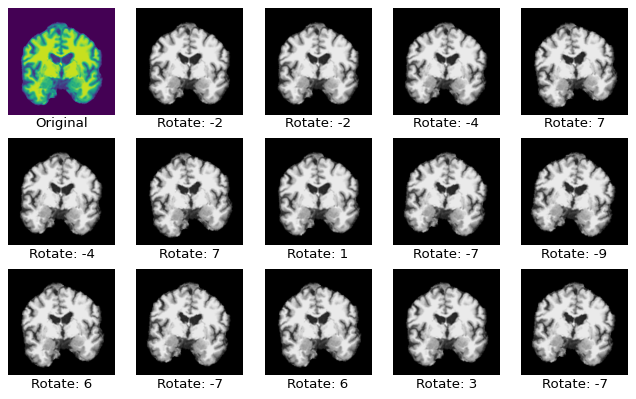

In [77]:
# 测试模块的功能
img_test = data[66].reshape(data.shape[2],data.shape[3],data.shape[4])
# 沿着指定轴旋转
t = RandomRotate_fixaxis(np.random.RandomState(), angle_spectrum=10)
rows = 3
cols = 5
fig = plt.figure(figsize=(2*cols, 2*rows),dpi=80) # 画布大小   # 绘制多子图

i=0
fig.add_subplot(rows, cols, i+1)
plt.imshow(np.rot90(img_test[:,(img_test.shape[1]//9)*5,:],1))
plt.axis('off')
plt.title("Original", y=-0.18) # 显示对应的标签
#plt.xticks([])
#plt.xticks([])
img_test_transform = t(img_test)
for i in range(1, 15):
    fig.add_subplot(rows, cols, i+1)
    figu,angle = t(img_test)
    plt.imshow(np.rot90(figu[:,(img_test.shape[1]//9)*5,:],1), cmap='gray')
    plt.axis('off')
    #plt.xticks([])
    #plt.xticks([])
    plt.title("Rotate: "+str(angle), y=-0.18) # 显示对应的标签
    
#plt.show()
plt.savefig('/data/huangxiang/国科大作业/Braincog/ADdiag/results/aug_rotate.png')

使用随机对比度调整方法

In [78]:
a = np.uint([1,2,3,4,5,133,246,225,255])
# a.astype('float')
t = RandomContrast_test(np.random.RandomState(), alpha=(0.5, 1.5))
x,y = t(a)
print(x)
print(y)
#print(x.dtype)
#print(np.clip(a,2,4))
#print(np.mean(a[a!=0]))

[ 33  34  35  35  36 121 196 182 202]
0.6626280462218013


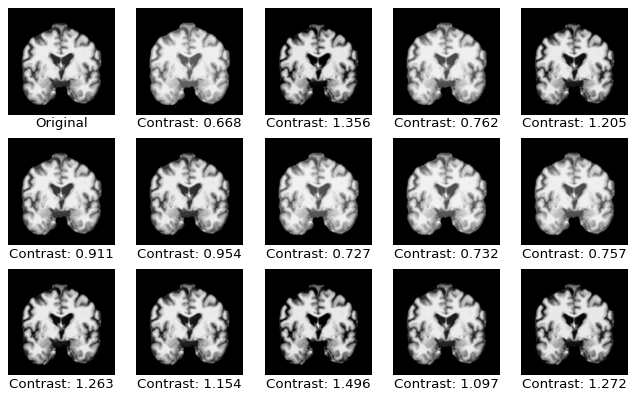

In [79]:
# 随机改变对比度
t = RandomContrast_test(np.random.RandomState(), alpha=(0.5, 1.5))  # 正式的时候设置为0.95，1.05吧

rows = 3
cols = 5
fig = plt.figure(figsize=(2*cols, 2*rows),dpi=80) # 画布大小   # 绘制多子图

i=0
fig.add_subplot(rows, cols, i+1)
plt.imshow(np.rot90(img_test[:,(img_test.shape[1]//9)*5+3,:],1), cmap='gray')
plt.axis('off')
plt.title("Original", y=-0.18) # 显示对应的标签
#plt.xticks([])
#plt.xticks([])
img_test_transform = t(img_test)
for i in range(1, 15):
    fig.add_subplot(rows, cols, i+1)
    # figu,alpha = t(img_test)
    figu,alpha = t(img_test)
    plt.imshow(np.rot90(figu[:,(img_test.shape[1]//9)*5+3,:],1), cmap='gray')
    plt.axis('off')
    #plt.xticks([])
    #plt.xticks([])
    plt.title("Contrast: "+str(alpha)[:5], y=-0.18) # 显示对应的标签
    
#plt.show()
plt.savefig('/data/huangxiang/国科大作业/Braincog/ADdiag/results/aug_contrast.png')

#### 2.5.7 构造dataset
dataset应当包含以下功能：
1. 数据增强
2. 输出数据大小
3. 打乱(shuffle)
4. 输出整体冠状面
5. 输出一张MRI的切片图
6. 标准化与数据dtype转化

In [80]:
# 先将数据和标签合并构造dataset
train_dataset = MyDataset(x_train,y_train)
test_dataset = MyDataset(x_test,y_test)

##### 2.5.7.1 测试数据集大小和类型

In [81]:
print(train_dataset.data.shape)
print(train_dataset.label.shape)
print(test_dataset.data.shape)
print(test_dataset.label.shape)

(336, 1, 182, 218, 182)
torch.Size([336])
(85, 1, 182, 218, 182)
torch.Size([85])


##### 2.5.7.2 测试两个数据集的绘图功能

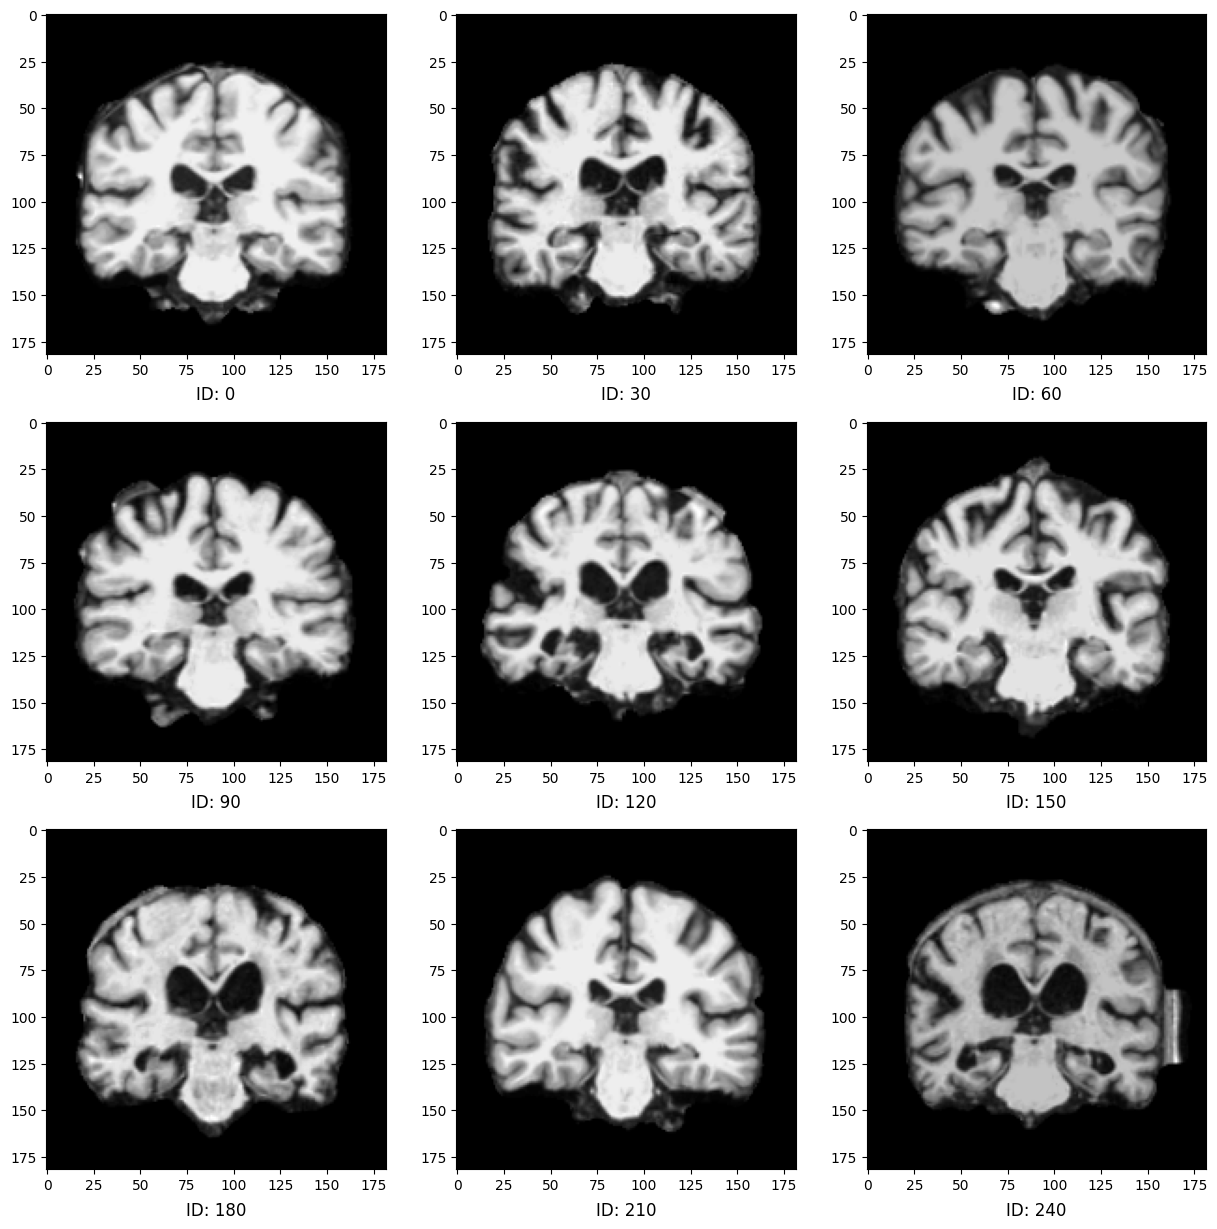

In [82]:
# 绘制总览图
train_dataset.plotall()

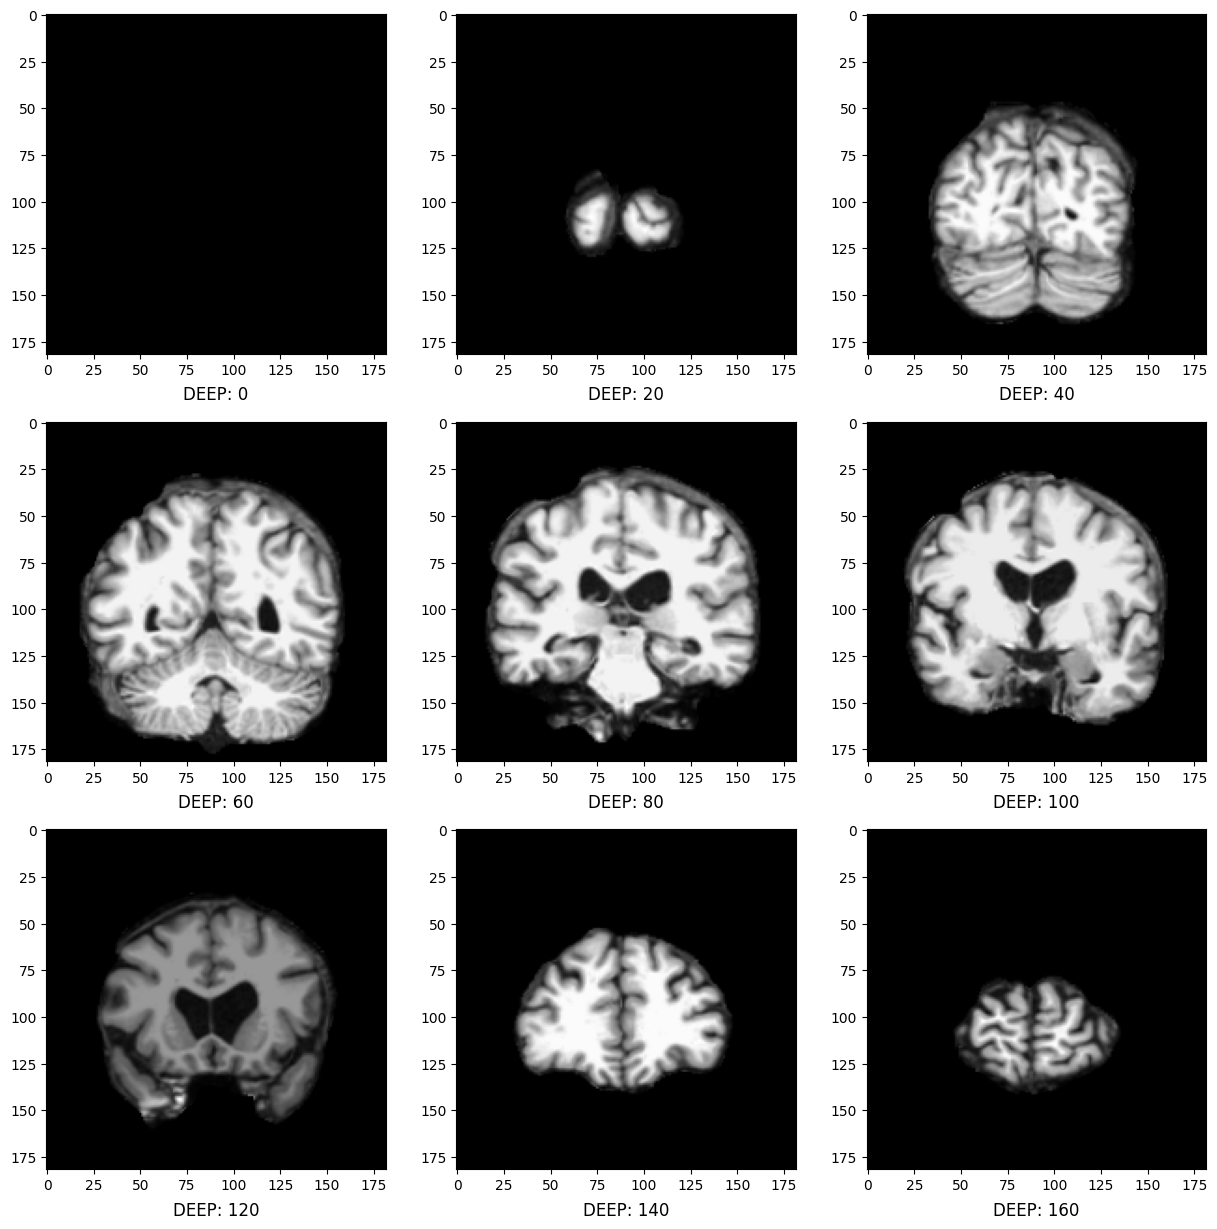

In [83]:
# 绘制特定id的图：
patient_id = 5
train_dataset.plotimg(patient_id)
#### 5.4.3 测试数据集归一化功能

##### 2.5.7.3 测试数据增强模块

In [84]:
a=train_dataset.data

In [85]:
#test = train_dataset.label
# 训练集数据增强
aug_num = 0
#train_dataset.aug_rotate(aug_num)
#train_dataset.aug_contract(aug_num)
train_dataset.aug_both(aug_num)

数据增强开始，此时的数据集大小为：
(336, 1, 182, 218, 182)
数据增强后的数据集大小为：
(336, 1, 182, 218, 182)
数据增强后的标签数量为：
torch.Size([336])


##### 2.5.7.4 测试打乱功能

In [86]:
train_dataset.shuffle()
test_dataset.shuffle()

[101  28 187 296   5  84 172  45 299 293 211 238 228 148 193 303 108 285
 229 124  60 302 154 100 175 239 102  70  19 153 226 334 241   2 251 246
  50  69  11  47 180  91 329 122 213   8  25  40 147 256  94 184 327 103
  13 275 311  58  74 167 295 274 173  10 174  76 133 314 254 136 328 222
 218 304 227 305  98 150 186  85 197 253 141 140 266 162 231 240  95  23
  36 115  55   0   3 317 248 249 263 319 155  99 130 138  77 308  34 189
  43 149 290 105  82 152  96 118 203 209  88 244  56  68 259 135 169  33
 235 120 236 276  49 221 216  12 163 250 191  20 298 121   6 326 315   7
 331  29 159 309  17 313  22 232 233  14 107 237 215 219 123  80 202 110
  32 188 322 267  37 286 116  75 257  79  61 289  30 125 273  66 196  21
 301 178 170 192 139 280  72 198  64 312 224 171 128 142  39  16 217  89
  51 333 335 132  38 268  31  92 200 230 208 306  44 245 292  26 205 117
  15 212 321 261 282 316 168  52  48 181 158 260 262  41 131 177 113  87
  81 243 111 294 272  93 144  27 104 265  54 207  6

##### 2.5.7.5 测试标准化功能

In [87]:
# print(len(train_dataset.label))
# np.random.seed(888)   # 设置随机数种子
# train_dataset.normalize()
# np.random.seed(888)   # 设置随机数种子
# test_dataset.normalize()     

# 为避免过分占用内存资源，选择在训练函数内进行标准化

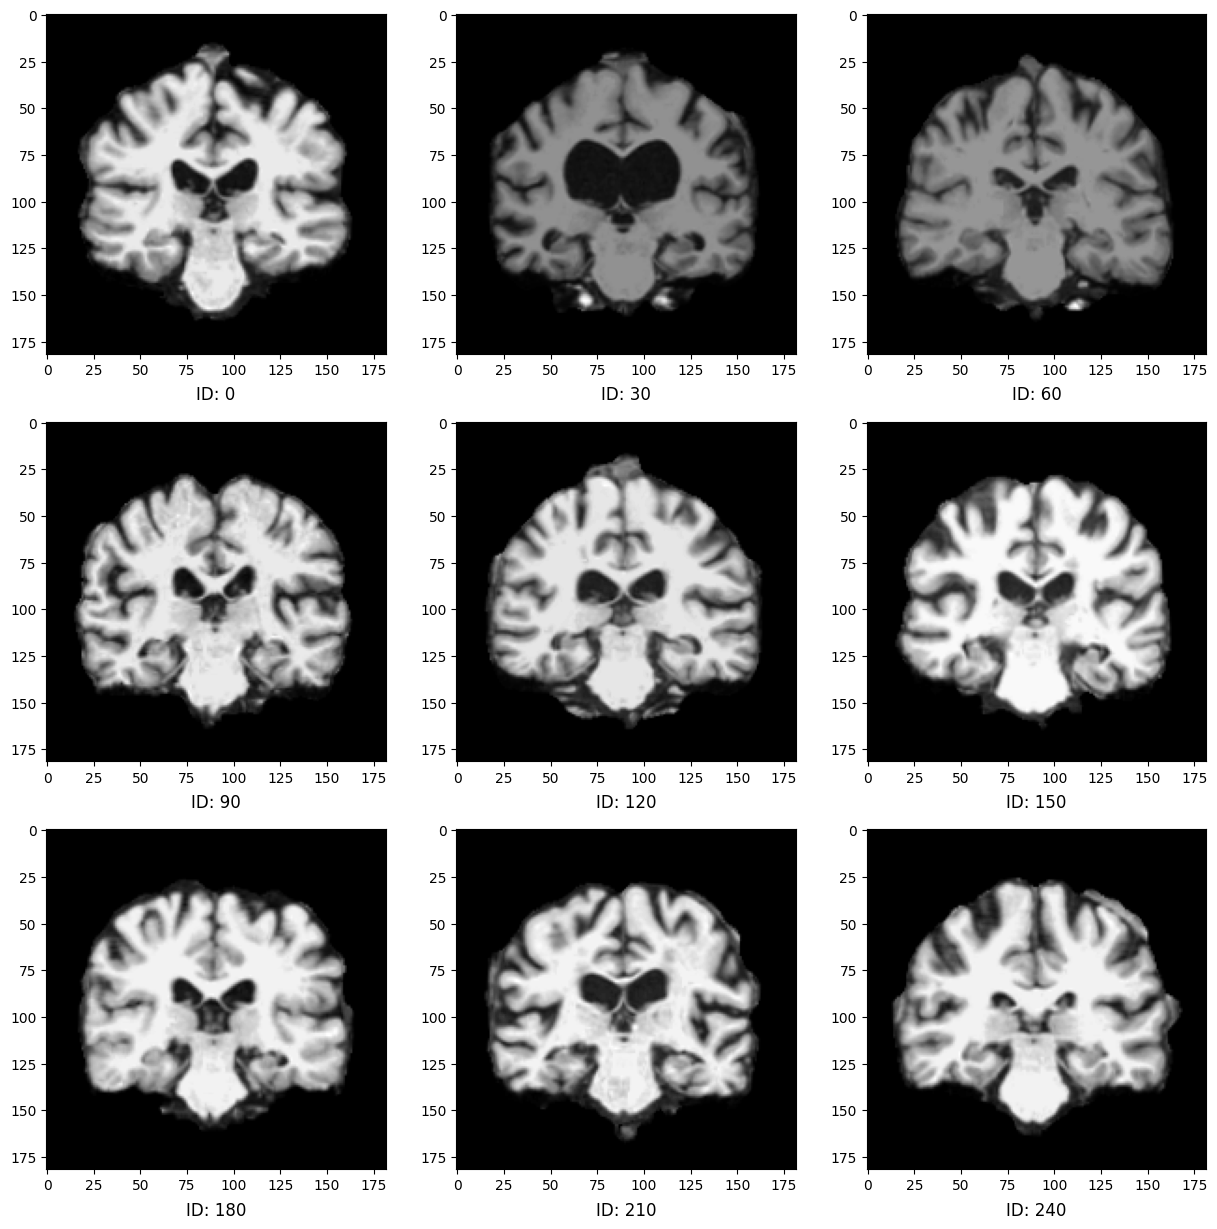

In [88]:
# 再画个图看看
train_dataset.plotall()

#### 2.5.8 构造dataloader

In [89]:
# 先整体测试一下效果
print('预处理前的训练数据：')
print(x_train.shape,x_train.dtype)
print('预处后的训练数据：')
train_dataset.data = train_dataset.data.astype(np.float32)
test_dataset.data = test_dataset.data.astype(np.float32)
print(train_dataset.data.shape,train_dataset.data.dtype)
print('训练集标签数：'+str(len(train_dataset.label)))

print('预处理前的测试数据：')
print(x_test.shape,x_test.dtype)
print('预处后的测试数据：')
print(test_dataset.data.shape,test_dataset.data.dtype)
print('测试集标签数：'+str(len(test_dataset.label)))

# 数据提取功能测试
img,target = train_dataset[0]
print(img.shape)
print(target)

预处理前的训练数据：
(336, 1, 182, 218, 182) uint8
预处后的训练数据：
(336, 1, 182, 218, 182) float32
训练集标签数：336
预处理前的测试数据：
(85, 1, 182, 218, 182) uint8
预处后的测试数据：
(85, 1, 182, 218, 182) float32
测试集标签数：85
(1, 182, 218, 182)
tensor(0)


In [90]:
# 创建dataloader
BATCH_SIZE = 8

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE)
testDataLoader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE)

#### 2.5.9 构造神经网络

In [ ]:
# 定义网络
# net = VGGNet_3D
net = RESNet_3d
# 打印网络结构
x_printnet = torch.randn(1, 1, 182, 218, 182)
for layer in net:
    x_printnet = layer(x_printnet)
    print(layer.__class__.__name__, 'Output shape:\t', x_printnet.shape)

Conv3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
BatchNorm3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
ReLU Output shape:	 torch.Size([1, 32, 58, 70, 58])
Conv3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
BatchNorm3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
ReLU Output shape:	 torch.Size([1, 32, 58, 70, 58])
MaxPool3d Output shape:	 torch.Size([1, 32, 29, 35, 29])
Conv3d Output shape:	 torch.Size([1, 64, 27, 33, 27])
BatchNorm3d Output shape:	 torch.Size([1, 64, 27, 33, 27])
ReLU Output shape:	 torch.Size([1, 64, 27, 33, 27])
Conv3d Output shape:	 torch.Size([1, 64, 25, 31, 25])
BatchNorm3d Output shape:	 torch.Size([1, 64, 25, 31, 25])
ReLU Output shape:	 torch.Size([1, 64, 25, 31, 25])
MaxPool3d Output shape:	 torch.Size([1, 64, 12, 15, 12])
Conv3d Output shape:	 torch.Size([1, 128, 10, 13, 10])
BatchNorm3d Output shape:	 torch.Size([1, 128, 10, 13, 10])
ReLU Output shape:	 torch.Size([1, 128, 10, 13, 10])
Conv3d Output shape:	 torch.Size([1, 128, 8, 11, 8])
Batch

In [92]:
# 转入cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)


Sequential(
  (0): Conv3d(1, 32, kernel_size=(9, 9, 9), stride=(3, 3, 3))
  (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (8): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (15): BatchNorm3d(128, eps=1e-0

#### 2.5.10 模型训练

In [93]:
# 训练模型测试
learning_rate = 0.0001
# momentum = 0.5
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 3e-4)  # adam优化器
#animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], # 监视器就是画图用的
#                            legend=['train loss', 'train acc', 'test acc'])
EPOCH = 50
#device = try_gpu()

# 训练信息保存
acc_list_test = []
loss_list_train = []
acc_list_train = []
loss_list_test = []
sen_list_train = []
sen_list_test = []
spc_list_train = []
spc_list_test = []
prc_list_train = []
prc_list_test = []
rec_list_train = []
rec_list_test = []

# 正式训练
np.random.seed(8686)   # 设置随机数种子
net.apply(weight_init)  # 权重初始化
flag = 0
for epoch in range(EPOCH):
    loss_train, acc_train,sen_train,spc_train,prc_train,rec_train = train(epoch)          # 训练函数，返回训练损失和训练准确率
    if acc_train == 1:
        flag += 1
    loss_test, acc_test, sen_test,spc_test,prc_test,rec_test= net_test(epoch)                             # 测试函数，返回测试准确率
    acc_list_test.append(acc_test)
    loss_list_train.append(loss_train)
    acc_list_train.append(acc_train)
    loss_list_test.append(loss_test)
    sen_list_train.append(sen_train)
    sen_list_test.append(sen_test)
    spc_list_train.append(spc_train)
    spc_list_test.append(spc_test)
    prc_list_train.append(prc_train)
    prc_list_test.append(prc_test)
    rec_list_train.append(rec_train)
    rec_list_test.append(rec_test)
    if flag == 5:
        break

torch.save(net.state_dict(), '/data/huangxiang/国科大作业/Braincog/ADdiag/model/3D-VGGNet.pth')

Running_correct: 203 Running_total: 336 Accuracy: 60.416666666666664
[epoch 1]: LOSS: 0.658 , ACC: 60.42 %,      SEN: 72.67 %, SPC: 49.14 %, PRC: 56.80 %, RCA: 72.67 %
[epoch 1/50]: Accuracy on test set: 61.2 %, LOSS: 0.614,      SEN: 61.29 %, SPC: 61.11 %, PRC: 47.50 %, RCA: 61.29 %
Running_correct: 241 Running_total: 336 Accuracy: 71.72619047619048
[epoch 2]: LOSS: 0.568 , ACC: 71.73 %,      SEN: 66.46 %, SPC: 76.57 %, PRC: 72.30 %, RCA: 66.46 %
[epoch 2/50]: Accuracy on test set: 76.5 %, LOSS: 0.520,      SEN: 58.06 %, SPC: 87.04 %, PRC: 72.00 %, RCA: 58.06 %
Running_correct: 279 Running_total: 336 Accuracy: 83.03571428571429
[epoch 3]: LOSS: 0.395 , ACC: 83.04 %,      SEN: 77.02 %, SPC: 88.57 %, PRC: 86.11 %, RCA: 77.02 %
[epoch 3/50]: Accuracy on test set: 71.8 %, LOSS: 0.574,      SEN: 29.03 %, SPC: 96.30 %, PRC: 81.82 %, RCA: 29.03 %
Running_correct: 276 Running_total: 336 Accuracy: 82.14285714285714
[epoch 4]: LOSS: 0.410 , ACC: 82.14 %,      SEN: 81.99 %, SPC: 82.29 %, PRC: 80

In [94]:
#net.apply(weight_init)  # 权重初始化，不会增大内存
# 只是一个测试
# from sys import getsizeof as getsize
# print(getsize(train_dataset.data))
# train_dataset.clear()
# print(getsize(train_dataset.data))

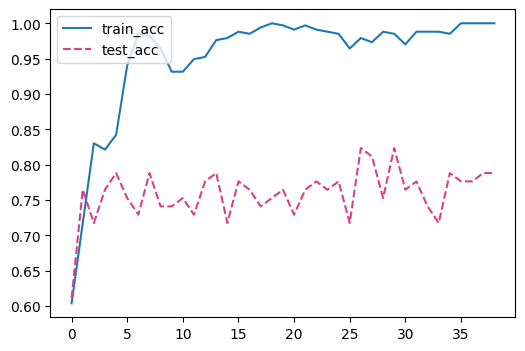

In [95]:
xx = np.arange(0,epoch+1)
fig = plt.figure(figsize=(6,4),dpi=100)  # 设置图片大小和分辨率，改图片大小+分辨率可以调节字体相对大小
plt.plot(xx,acc_list_train,label='train_acc')            # 还能设置color,linestyle,linewidth,
#plt.plot(xx,loss_list_train,label='train_loss')            # 还能设置color,linestyle,linewidth,
plt.plot(xx,acc_list_test,label='test_acc',linestyle='--',color='#DB4083')    # color可以设置色号

# 添加图例
plt.legend(loc=2)                            # 可以通过loc设置位置
plt.show()

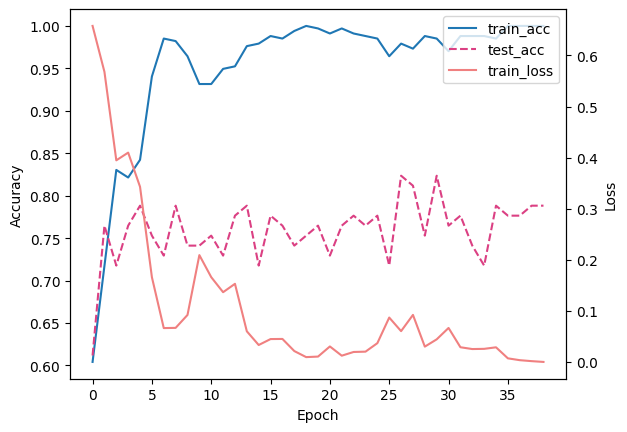

In [96]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=0)
 
ax1.plot(xx,acc_list_train,label='train_acc')
ax1.plot(xx,acc_list_test,label='test_acc',linestyle='--',color='#DB4083')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
 
ax2 = ax1.twinx()
ax2.plot(xx, loss_list_train,color='lightcoral',label="train_loss")
#ax2.plot(xx, loss_list_test,color='orange',linestyle='--',label="test_loss")
ax2.set_ylabel("Loss")
 
fig.legend(bbox_to_anchor=(1, 1),bbox_transform=ax1.transAxes)
plt.show()